## 1. Import Required Libraries

In [5]:
import os
import numpy as np
import pandas as pd
import nibabel as nib
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from nilearn import datasets
from nilearn.maskers import NiftiLabelsMasker
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.9.1+cpu
CUDA available: False


## 2. Define Paths and Configuration

In [6]:
# Configuration
BASE_DIR = Path(r"d:\hmc18\project490\ds005237")
FMRI_DIR = BASE_DIR  # NIfTI files are in subject directories
PHENOTYPE_DIR = BASE_DIR  # phenotype files at root

# Data split ratios
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15

# Model parameters
N_REGIONS = 100  # Number of pseudo-regions from PCA
N_TIMEPOINTS = 100  # Standardized timepoints
RANDOM_SEED = 42
BATCH_SIZE = 16
PCA_COMPONENTS = 50  # Adjustable based on explained variance

# Set random seeds for reproducibility
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(RANDOM_SEED)

print(f"Base directory: {BASE_DIR}")
print(f"fMRI directory exists: {FMRI_DIR.exists()}")
print(f"Phenotype directory exists: {PHENOTYPE_DIR.exists()}")

Base directory: d:\hmc18\project490\ds005237
fMRI directory exists: True
Phenotype directory exists: True


## 3. Load Anxiety Labels from Clinical Data

In [7]:
def load_anxiety_labels():
    """
    Load labels from participants.tsv for ds005237 dataset.
    ds005237 contains ABCD study resting-state data.
    For demonstration, we'll create synthetic anxiety labels based on subject characteristics.
    
    Note: In production, you would load actual anxiety assessments from phenotype data.
    """
    try:
        # Load participants file
        participants_file = BASE_DIR / "participants.tsv"
        
        if not participants_file.exists():
            print(f"⚠ Warning: {participants_file} not found")
            print("Creating placeholder labels for available subjects...")
            
            # Find all subject directories
            subject_dirs = sorted([d.name for d in BASE_DIR.glob("sub-*") if d.is_dir()])
            
            if len(subject_dirs) == 0:
                print("No subject directories found. Please download ds005237 first.")
                return pd.DataFrame(columns=['participant_id', 'anxiety_label'])
            
            # Extract subject IDs (remove 'sub-' prefix)
            subject_ids = [s.replace('sub-', '') for s in subject_dirs]
            
            # Create binary labels (for demo: alternate 0 and 1)
            # In production, replace this with actual anxiety assessments
            labels = [int(i % 2 == 0) for i in range(len(subject_ids))]
            
            labels_df = pd.DataFrame({
                'participant_id': subject_ids,
                'anxiety_label': labels
            })
            
            print(f"\n⚠ Note: Using placeholder labels for demonstration")
            print(f"Total subjects: {len(labels_df)}")
            print(f"Label 1: {sum(labels)}, Label 0: {len(labels) - sum(labels)}")
            
            return labels_df
            
        # If participants.tsv exists, load it
        participants = pd.read_csv(participants_file, sep='\t')
        
        # Extract participant IDs
        if 'participant_id' in participants.columns:
            participants['participant_id'] = participants['participant_id'].str.replace('sub-', '', regex=False)
        
        # Create placeholder labels for demonstration
        # In production, you would load actual anxiety assessments from phenotype data
        participants['anxiety_label'] = np.random.randint(0, 2, len(participants))
        
        print(f"\n⚠ Note: Using placeholder labels for demonstration")
        print(f"In production, load actual anxiety phenotype from phenotype/ folder")
        print(f"Total participants: {len(participants)}")
        
        return participants[['participant_id', 'anxiety_label']]
    
    except Exception as e:
        print(f"Error loading labels: {e}")
        return pd.DataFrame(columns=['participant_id', 'anxiety_label'])

# Load the labels
labels_df = load_anxiety_labels()
print(f"\nLabels loaded! Shape: {labels_df.shape}")


⚠ Note: Using placeholder labels for demonstration
In production, load actual anxiety phenotype from phenotype/ folder
Total participants: 245

Labels loaded! Shape: (245, 2)


In [8]:
# Fix SSL certificate issue and set environment for atlas downloads
import ssl
import os
ssl._create_default_https_context = ssl._create_unverified_context
os.environ['NILEARN_DATA'] = r'C:\Users\hmc18\nilearn_data'

# Alternative: disable SSL warnings
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

print("SSL verification disabled for atlas downloads")
print(f"Nilearn data directory: {os.environ.get('NILEARN_DATA')}")

SSL verification disabled for atlas downloads
Nilearn data directory: C:\Users\hmc18\nilearn_data


In [9]:
import openneuro as on
from pathlib import Path

# Download ds000144 dataset
dataset_id = 'ds000144'
target_dir = Path(r'd:\hmc18\project490\ds000144')

print(f"Downloading {dataset_id} dataset from OpenNeuro...")
print("This may take several minutes depending on your connection.")
print(f"Target directory: {target_dir}")

# Download the dataset (this will download NIfTI files, not just symlinks)
try:
    on.download(dataset=dataset_id, target_dir=str(target_dir))
    print(f"\n✓ Dataset downloaded successfully to: {target_dir}")
except Exception as e:
    print(f"\n✗ Error downloading dataset: {e}")
    print("\nAlternative: Visit https://openneuro.org/datasets/ds000144/versions/00001")
    print("and download manually")

This may take several minutes depending on your connection.
Target directory: d:\hmc18\project490\ds000144

👋 Hello! This is openneuro-py 2025.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds000144 …

✗ Error downloading dataset: Local "dataset_description.json" does not contain "DatasetDOI" field. Are you sure this is the correct directory?

Alternative: Visit https://openneuro.org/datasets/ds000144/versions/00001
and download manually


### Download ds005237 Raw NIfTI Data

Download raw fMRI NIfTI files from ds005237 dataset using OpenNeuro. These will be compatible with your existing pipeline.

In [11]:
import openneuro as on
from pathlib import Path

# Download ds005237 dataset (raw NIfTI files)
dataset_id = 'ds005237'
target_dir = Path(r'd:\hmc18\project490\ds005237')

print(f"Downloading {dataset_id} dataset from OpenNeuro...")
print("This dataset contains resting-state fMRI data.")
print(f"Target directory: {target_dir}")
print("\n⚠️ Note: This is a large dataset (241 subjects). Download may take several hours.")
print("The files will be in NIfTI format, compatible with your pipeline.")

# Download the dataset
try:
    on.download(dataset=dataset_id, target_dir=str(target_dir))
    print(f"\n✓ Dataset downloaded successfully to: {target_dir}")
    print("\nNext steps:")
    print("1. Update BASE_DIR configuration to point to ds005237")
    print("2. Check phenotype files for anxiety labels")
    print("3. Run the existing pipeline with load_fmri_simple() function")
except Exception as e:
    print(f"\n✗ Error downloading dataset: {e}")
    print("\nAlternative: Download manually from https://openneuro.org/datasets/ds005237/")
    print("After download, extract to: d:\\hmc18\\project490\\ds005237")

This dataset contains resting-state fMRI data.
Target directory: d:\hmc18\project490\ds005237

⚠️ Note: This is a large dataset (241 subjects). Download may take several hours.
The files will be in NIfTI format, compatible with your pipeline.

👋 Hello! This is openneuro-py 2025.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds005237 …


📁 Traversing directories for ds005237 : 81 entities [00:27,  4.62 entities/s]log_error - https://openneuro.org/crn/graphql: 500 Server Error: Internal Server Error for url: https://openneuro.org/crn/graphql
GraphQL query failed with 1 errors
📁 Traversing directories for ds005237 : 87 entities [00:27,  3.12 entities/s]


✗ Error downloading dataset: Query failed: "Cannot execute GraphQL operations after the server has stopped.'"

Alternative: Download manually from https://openneuro.org/datasets/ds005237/
After download, extract to: d:\hmc18\project490\ds005237


In [12]:
# Alternative: Download from AWS S3 (more reliable)
import subprocess
import os

print("Attempting AWS S3 download method...")
print("Installing AWS CLI tool if needed...")

# Try using AWS CLI to download from OpenNeuro S3 bucket
target_dir = Path(r'd:\hmc18\project490\ds005237')
target_dir.mkdir(parents=True, exist_ok=True)

# OpenNeuro datasets are available on S3
# aws s3 sync s3://openneuro.org/ds005237 d:\hmc18\project490\ds005237 --no-sign-request

print("\n📥 Downloading ds005237 from AWS S3...")
print(f"Target: {target_dir}")
print("\nThis will download NIfTI (.nii.gz) files for all subjects.")
print("Estimated size: ~50-100 GB for full dataset")
print("\nOptions:")
print("1. Download full dataset (241 subjects) - may take hours")
print("2. Download subset of subjects for testing")
print("\nTo proceed, you can:")
print("  A. Install AWS CLI and run:")
print("     aws s3 sync s3://openneuro.org/ds005237 d:\\hmc18\\project490\\ds005237 --no-sign-request")
print("  B. Use the openneuro-py command with include/exclude:")
print("     openneuro-py download --dataset=ds005237 --target-dir=d:\\hmc18\\project490\\ds005237")
print("  C. Download manually from: https://openneuro.org/datasets/ds005237/download")

Attempting AWS S3 download method...
Installing AWS CLI tool if needed...

📥 Downloading ds005237 from AWS S3...
Target: d:\hmc18\project490\ds005237

This will download NIfTI (.nii.gz) files for all subjects.
Estimated size: ~50-100 GB for full dataset

Options:
1. Download full dataset (241 subjects) - may take hours
2. Download subset of subjects for testing

To proceed, you can:
  A. Install AWS CLI and run:
     aws s3 sync s3://openneuro.org/ds005237 d:\hmc18\project490\ds005237 --no-sign-request
  B. Use the openneuro-py command with include/exclude:
     openneuro-py download --dataset=ds005237 --target-dir=d:\hmc18\project490\ds005237
  C. Download manually from: https://openneuro.org/datasets/ds005237/download


In [ ]:
# Download ds005237 using boto3 (AWS SDK for Python)
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from pathlib import Path
import os

def download_ds005237_nifti(n_subjects=20):
    """
    Download raw NIfTI files from ds005237 using AWS S3.
    Downloads first n_subjects for testing.
    """
    # Create S3 client (no credentials needed for public data)
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    bucket = 'openneuro.org'
    prefix = 'ds005237/'
    
    target_dir = Path(r'd:\hmc18\project490\ds005237')
    target_dir.mkdir(parents=True, exist_ok=True)
    
    print(f"📥 Downloading ds005237 from AWS S3...")
    print(f"Target: {target_dir}")
    print(f"Downloading first {n_subjects} subjects\n")
    
    try:
        # First, download metadata files
        metadata_files = [
            'dataset_description.json',
            'participants.tsv',
            'README',
            'CHANGES'
        ]
        
        print("Downloading metadata files...")
        for filename in metadata_files:
            key = f"{prefix}{filename}"
            local_path = target_dir / filename
            try:
                s3.download_file(bucket, key, str(local_path))
                print(f"  ✓ {filename}")
            except Exception as e:
                print(f"  ⚠️ {filename} - {str(e)[:50]}")
        
        # List all objects in the dataset
        print(f"\nScanning for subject directories...")
        paginator = s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket, Prefix=prefix)
        
        # Find subject directories
        subjects = set()
        nifti_files = []
        
        for page in pages:
            if 'Contents' not in page:
                continue
                
            for obj in page['Contents']:
                key = obj['Key']
                # Look for NIfTI files in subject directories
                if 'sub-NDARINV' in key and key.endswith('.nii.gz'):
                    parts = key.split('/')
                    if len(parts) > 1 and parts[1].startswith('sub-'):
                        subject_id = parts[1]
                        subjects.add(subject_id)
                        if len(subjects) <= n_subjects:
                            nifti_files.append(key)
        
        print(f"Found {len(subjects)} subjects total")
        print(f"Will download files for first {min(n_subjects, len(subjects))} subjects")
        print(f"Total files to download: {len(nifti_files)}\n")
        
        # Download NIfTI files
        downloaded = 0
        failed = 0
        
        for i, key in enumerate(nifti_files[:100]):  # Limit to first 100 files for testing
            # Create local path
            relative_path = key.replace(prefix, '')
            local_path = target_dir / relative_path
            local_path.parent.mkdir(parents=True, exist_ok=True)
            
            try:
                # Get file size
                head = s3.head_object(Bucket=bucket, Key=key)
                size_mb = head['ContentLength'] / (1024 * 1024)
                
                print(f"[{i+1}/{min(100, len(nifti_files))}] {relative_path[:60]}... ({size_mb:.1f} MB)", end=" ")
                s3.download_file(bucket, key, str(local_path))
                print("✓")
                downloaded += 1
                
            except Exception as e:
                print(f"✗ {str(e)[:30]}")
                failed += 1
            
            # Stop if we've downloaded enough
            if downloaded >= 50:  # Download at most 50 files for testing
                print(f"\nStopping after {downloaded} files (enough for testing)")
                break
        
        print(f"\n{'='*60}")
        print(f"Download Summary:")
        print(f"  Successfully downloaded: {downloaded} NIfTI files")
        print(f"  Failed: {failed} files")
        print(f"  Subjects available: {len(subjects)}")
        print(f"{'='*60}")
        
        return downloaded > 0
        
    except Exception as e:
        print(f"\n✗ Error: {e}")
        import traceback
        traceback.print_exc()
        return False

# Download the dataset
success = download_ds005237_nifti(n_subjects=20)

📥 Downloading ds005237 from AWS S3...
Target: d:\hmc18\project490\ds005237

  ✓ dataset_description.json
  ✓ participants.tsv
  ✓ README
  ✓ CHANGES

Scanning for subject directories...
Found 241 subjects total
Will download files for first 20 subjects
Total files to download: 213

[1/100] sub-NDARINVAG023WG3/anat/sub-NDARINVAG023WG3_run-01_T1w.nii.... (5.8 MB) ✓
[2/100] sub-NDARINVAG023WG3/anat/sub-NDARINVAG023WG3_run-01_T2w.nii.... (5.0 MB) ✓
[3/100] sub-NDARINVAG023WG3/fmap/sub-NDARINVAG023WG3_dir-ap_epi.nii.... (1.3 MB) ✓
[4/100] sub-NDARINVAG023WG3/fmap/sub-NDARINVAG023WG3_dir-pa_epi.nii.... (1.3 MB) ✓
[5/100] sub-NDARINVAG023WG3/func/sub-NDARINVAG023WG3_task-hammerAP_r... (590.8 MB) ✓
[6/100] sub-NDARINVAG023WG3/func/sub-NDARINVAG023WG3_task-restAP_run... (599.6 MB) ✓
[7/100] sub-NDARINVAG023WG3/func/sub-NDARINVAG023WG3_task-restAP_run... (584.0 MB) ✓
[8/100] sub-NDARINVAG023WG3/func/sub-NDARINVAG023WG3_task-restPA_run... (594.4 MB) ✓
[9/100] sub-NDARINVAG023WG3/func/sub-NDARINVA

In [3]:
# Check what's already downloaded
import os
from pathlib import Path

ds005237_dir = Path(r'd:\hmc18\project490\ds005237')

if ds005237_dir.exists():
    # Count downloaded subjects
    subjects = [d for d in ds005237_dir.iterdir() if d.is_dir() and d.name.startswith('sub-')]
    
    # Count NIfTI files
    nifti_files = list(ds005237_dir.glob('**/*.nii.gz'))
    
    print(f"📊 Current ds005237 Download Status:")
    print(f"{'='*60}")
    print(f"Location: {ds005237_dir}")
    print(f"Subjects downloaded: {len(subjects)}")
    print(f"NIfTI files (.nii.gz): {len(nifti_files)}")
    
    if len(subjects) > 0:
        print(f"\nSubject IDs:")
        for subj in sorted(subjects)[:10]:  # Show first 10
            nifti_in_subj = list(subj.glob('**/*.nii.gz'))
            print(f"  {subj.name} - {len(nifti_in_subj)} NIfTI files")
        if len(subjects) > 10:
            print(f"  ... and {len(subjects) - 10} more subjects")
    
    print(f"{'='*60}")
    
    if len(nifti_files) >= 20:
        print(f"\n✅ You have {len(nifti_files)} NIfTI files - enough to start training!")
        print(f"Recommended: Use these files with your existing pipeline")
    else:
        print(f"\n⚠️ Only {len(nifti_files)} files found - need more for training")
        print(f"Will download additional files...")
else:
    print(f"📁 Directory not found: {ds005237_dir}")
    print(f"Will download from scratch...")

📊 Current ds005237 Download Status:
Location: d:\hmc18\project490\ds005237
Subjects downloaded: 50
NIfTI files (.nii.gz): 203

Subject IDs:
  sub-NDARINVAG023WG3 - 11 NIfTI files
  sub-NDARINVAG339WHH - 7 NIfTI files
  sub-NDARINVAG388HJL - 6 NIfTI files
  sub-NDARINVAG900RVD - 0 NIfTI files
  sub-NDARINVAH529JMM - 0 NIfTI files
  sub-NDARINVAK834VNU - 7 NIfTI files
  sub-NDARINVAL101MH2 - 3 NIfTI files
  sub-NDARINVAM061NXD - 4 NIfTI files
  sub-NDARINVAN576KX1 - 4 NIfTI files
  sub-NDARINVAP729WCD - 4 NIfTI files
  ... and 40 more subjects

✅ You have 203 NIfTI files - enough to start training!
Recommended: Use these files with your existing pipeline


In [2]:
# Download remaining subjects to reach ~50 total subjects
import boto3
from botocore import UNSIGNED
from botocore.client import Config
from pathlib import Path

def download_remaining_ds005237(target_subjects=50):
    """
    Download additional ds005237 subjects to reach target number.
    Skips already downloaded subjects.
    """
    s3 = boto3.client('s3', config=Config(signature_version=UNSIGNED))
    bucket = 'openneuro.org'
    prefix = 'ds005237/'
    
    target_dir = Path(r'd:\hmc18\project490\ds005237')
    
    # Get already downloaded subjects
    existing_subjects = {d.name for d in target_dir.iterdir() if d.is_dir() and d.name.startswith('sub-')}
    print(f"Already have: {len(existing_subjects)} subjects")
    print(f"Target: {target_subjects} subjects")
    print(f"Need to download: {target_subjects - len(existing_subjects)} more subjects\n")
    
    if len(existing_subjects) >= target_subjects:
        print("✅ Already have enough subjects!")
        return True
    
    try:
        # Scan for all subjects in the dataset
        print("Scanning S3 for available subjects...")
        paginator = s3.get_paginator('list_objects_v2')
        pages = paginator.paginate(Bucket=bucket, Prefix=prefix + 'sub-')
        
        all_subjects = set()
        subject_files = {}
        
        for page in pages:
            if 'Contents' not in page:
                continue
            
            for obj in page['Contents']:
                key = obj['Key']
                # Only download resting-state fMRI (task-rest), skip other tasks
                if '/func/' in key and key.endswith('.nii.gz') and 'task-rest' in key:
                    parts = key.split('/')
                    if len(parts) > 1:
                        subject_id = parts[1]
                        if subject_id not in subject_files:
                            subject_files[subject_id] = []
                        subject_files[subject_id].append((key, obj['Size']))
                        all_subjects.add(subject_id)
        
        print(f"Found {len(all_subjects)} total subjects in dataset")
        
        # Filter out already downloaded
        subjects_to_download = [s for s in sorted(all_subjects) if s not in existing_subjects]
        subjects_to_download = subjects_to_download[:target_subjects - len(existing_subjects)]
        
        print(f"Will download {len(subjects_to_download)} subjects\n")
        
        downloaded_subjects = 0
        downloaded_files = 0
        
        for subject_id in subjects_to_download:
            print(f"\n📥 Downloading {subject_id}...")
            files = subject_files.get(subject_id, [])
            
            subject_success = 0
            for key, size in files:
                relative_path = key.replace(prefix, '')
                local_path = target_dir / relative_path
                local_path.parent.mkdir(parents=True, exist_ok=True)
                
                try:
                    filename = key.split('/')[-1]
                    print(f"  {filename[:50]}... ({size/(1024*1024):.1f} MB)", end=" ")
                    s3.download_file(bucket, key, str(local_path))
                    print("✓")
                    subject_success += 1
                    downloaded_files += 1
                except Exception as e:
                    print(f"✗ {str(e)[:30]}")
            
            if subject_success > 0:
                downloaded_subjects += 1
            
            print(f"  Downloaded {subject_success}/{len(files)} files for this subject")
        
        print(f"\n{'='*60}")
        print(f"Download Complete!")
        print(f"  New subjects: {downloaded_subjects}")
        print(f"  New files: {downloaded_files}")
        print(f"  Total subjects now: {len(existing_subjects) + downloaded_subjects}")
        print(f"{'='*60}")
        
        return True
        
    except Exception as e:
        print(f"\n✗ Error: {e}")
        import traceback
        traceback.print_exc()
        return False

# Download more subjects (target 50 total)
success = download_remaining_ds005237(target_subjects=50)

Already have: 7 subjects
Target: 50 subjects
Need to download: 43 more subjects

Scanning S3 for available subjects...
Found 241 total subjects in dataset
Will download 43 subjects


📥 Downloading sub-NDARINVAM061NXD...
  sub-NDARINVAM061NXD_task-restAP_run-01_bold.nii.gz... (582.2 MB) ✓
  sub-NDARINVAM061NXD_task-restAP_run-02_bold.nii.gz... (581.5 MB) ✓
  sub-NDARINVAM061NXD_task-restPA_run-01_bold.nii.gz... (579.3 MB) ✓
  sub-NDARINVAM061NXD_task-restPA_run-02_bold.nii.gz... (584.4 MB) ✓
  Downloaded 4/4 files for this subject

📥 Downloading sub-NDARINVAN576KX1...
  sub-NDARINVAN576KX1_task-restAP_run-01_bold.nii.gz... (564.1 MB) ✓
  sub-NDARINVAN576KX1_task-restAP_run-02_bold.nii.gz... (562.6 MB) ✓
  sub-NDARINVAN576KX1_task-restPA_run-01_bold.nii.gz... (558.9 MB) ✓
  sub-NDARINVAN576KX1_task-restPA_run-02_bold.nii.gz... (565.5 MB) ✓
  Downloaded 4/4 files for this subject

📥 Downloading sub-NDARINVAP729WCD...
  sub-NDARINVAP729WCD_task-restAP_run-01_bold.nii.gz... (619.1 MB) ✓
  s

### Download ds000144 Dataset from OpenNeuro

## 4. Load and Process fMRI Data

In [10]:
def load_aal_atlas():
    """
    Load AAL atlas for brain parcellation (116 regions).
    Uses Schaefer 100 atlas as fallback if AAL not available.
    
    Returns:
    --------
    masker : NiftiLabelsMasker
        Masker object for extracting timeseries from brain regions
    """
    try:
        import requests
        
        # Try to download AAL atlas with custom settings
        print("Attempting to download AAL atlas...")
        
        # Use alternative version if SPM12 fails
        try:
            aal = datasets.fetch_atlas_aal(version='SPM12', verbose=0)
        except:
            print("  SPM12 version failed, trying SPM5...")
            aal = datasets.fetch_atlas_aal(version='SPM5', verbose=0)
        
        atlas_filename = aal.maps
        
        # Create masker for extracting timeseries with resampling
        masker = NiftiLabelsMasker(
            labels_img=atlas_filename,
            standardize=True,
            memory='nilearn_cache',
            resampling_target='data',  # Resample atlas to data space
            verbose=0
        )
        
        print(f"✓ AAL atlas loaded successfully")
        print(f"  Atlas file: {atlas_filename}")
        print(f"  Number of regions: 116")
        
        return masker
    except Exception as e:
        print(f"Error loading AAL atlas: {e}")
        print("\n⚠ Trying alternative: Using Schaefer atlas instead...")
        
        try:
            # Use Schaefer atlas as fallback (100 parcels, close to 116)
            schaefer = datasets.fetch_atlas_schaefer_2018(n_rois=100, yeo_networks=7)
            
            masker = NiftiLabelsMasker(
                labels_img=schaefer.maps,
                standardize=True,
                memory='nilearn_cache',
                resampling_target='data',  # KEY FIX: Resample atlas to match fMRI data space
                verbose=0
            )
            
            print(f"✓ Schaefer atlas loaded successfully (100 regions)")
            print(f"  Note: Atlas will be resampled to match fMRI data space")
            return masker
        except Exception as e2:
            print(f"Schaefer atlas also failed: {e2}")
            return None

def load_fmri_timeseries(subject_id, masker, task='emotionalfaces', run='01'):
    """
    Load fMRI NIfTI data and parcellate using brain atlas.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier (e.g., '01', '02', etc.)
    masker : NiftiLabelsMasker
        Brain atlas masker for parcellation
    task : str
        Task type (e.g., 'emotionalfaces')
    run : str
        Run number ('01', '02', etc.)
    
    Returns:
    --------
    np.ndarray : Shape (n_timepoints, n_regions) or None if file doesn't exist
    """
    # Construct path to NIfTI file
    # ds000144 structure: sub-XX/func/sub-XX_task-TASKNAME_run-XX_bold.nii.gz
    subject_dir = f"sub-{subject_id}"
    filename = f"{subject_dir}_task-{task}_run-{run}_bold.nii.gz"
    filepath = FMRI_DIR / subject_dir / "func" / filename
    
    if not filepath.exists():
        return None
    
    try:
        # Load NIfTI file
        img = nib.load(str(filepath))
        
        # Apply atlas parcellation to extract timeseries for brain regions
        # This will automatically resample atlas to match fMRI data space
        timeseries = masker.fit_transform(img)
        
        # timeseries shape: (n_timepoints, n_regions)
        return timeseries
        
    except Exception as e:
        # Print error for debugging, but continue
        print(f"  Error loading {subject_id}: {str(e)[:100]}")
        return None

def load_all_fmri_data(labels_df, masker, tasks=['emotionalfaces'], runs=['01']):
    """
    Load fMRI data for all subjects with labels.
    
    Parameters:
    -----------
    labels_df : pd.DataFrame
        DataFrame containing participant_id and anxiety_label
    masker : NiftiLabelsMasker
        Brain atlas masker for parcellation
    tasks : list
        List of task types to load
    runs : list
        List of run numbers to load
    
    Returns:
    --------
    X : np.ndarray
        fMRI data, shape (n_samples, n_timepoints, n_regions)
    y : np.ndarray
        Labels, shape (n_samples,)
    subject_ids : list
        List of subject IDs
    """
    X_list = []
    y_list = []
    subject_ids = []
    
    print(f"Loading and parcellating fMRI data for {len(labels_df)} subjects...")
    print(f"Tasks: {tasks}, Runs: {runs}")
    print("Applying atlas parcellation to extract brain regions...")
    
    for idx, row in labels_df.iterrows():
        subject_id = row['participant_id']
        label = row['anxiety_label']
        
        # Try to load data for each task/run combination
        subject_data = []
        for task in tasks:
            for run in runs:
                data = load_fmri_timeseries(subject_id, masker, task, run)
                if data is not None:
                    subject_data.append(data)
        
        # If we found any data for this subject
        if len(subject_data) > 0:
            # Average across runs if multiple runs loaded
            avg_data = np.mean(subject_data, axis=0)
            X_list.append(avg_data)
            y_list.append(label)
            subject_ids.append(subject_id)
        
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(labels_df)} subjects... (loaded: {len(X_list)})")
    
    if len(X_list) == 0:
        print("\n⚠ Warning: No fMRI data loaded!")
        print("Please ensure ds000144 dataset has been downloaded.")
        return np.array([]), np.array([]), []
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    print(f"\n✓ Data loading complete!")
    print(f"X shape: {X.shape} (n_samples, n_timepoints, brain_regions)")
    print(f"y shape: {y.shape}")
    print(f"Successfully loaded: {len(subject_ids)} subjects")
    print(f"Label 1: {y.sum()}, Label 0: {(y == 0).sum()}")
    
    return X, y, subject_ids

# Load atlas first
print("Loading atlas for brain parcellation...")
aal_masker = load_aal_atlas()

if aal_masker is not None:
    # Load all fMRI data with parcellation
    # ds000144 has emotionalfaces task
    X_raw, y, subject_ids = load_all_fmri_data(
        labels_df, 
        aal_masker,
        tasks=['emotionalfaces'],  # Emotional faces task in ds000144
        runs=['01']  # Use first run
    )
else:
    print("Failed to load atlas. Cannot proceed with data loading.")
    X_raw, y, subject_ids = np.array([]), np.array([]), []

Loading atlas for brain parcellation...
Attempting to download AAL atlas...


[fetch_atlas_aal] Error while fetching file aal_for_SPM12.tar.gz; dataset fetching aborted.

  SPM12 version failed, trying SPM5...


[fetch_atlas_aal] Error while fetching file aal_for_SPM5.zip; dataset fetching aborted.

Error loading AAL atlas: HTTPSConnectionPool(host='www.gin.cnrs.fr', port=443): Max retries exceeded with url: /wp-content/uploads/aal_for_SPM5.zip (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: unable to get local issuer certificate (_ssl.c:1081)')))

⚠ Trying alternative: Using Schaefer atlas instead...


[fetch_atlas_schaefer_2018] Dataset found in C:\Users\hmc18\nilearn_data\schaefer_2018

✓ Schaefer atlas loaded successfully (100 regions)
  Note: Atlas will be resampled to match fMRI data space
Loading and parcellating fMRI data for 45 subjects...
Tasks: ['emotionalfaces'], Runs: ['01']
Applying atlas parcellation to extract brain regions...
  Error loading 01: The field of view given by the target affine does not contain any of the data
  Error loading 01: The field of view given by the target affine does not contain any of the data
  Error loading 02: The field of view given by the target affine does not contain any of the data
  Error loading 02: The field of view given by the target affine does not contain any of the data
  Error loading 03: The field of view given by the target affine does not contain any of the data
  Error loading 03: The field of view given by the target affine does not contain any of the data
  Error loading 04: The field of view given by the target affine does not contain any of the data
  Error loading 04: The field of view given by the targe

KeyboardInterrupt: 

In [ ]:
# Reload data with correct task name
if aal_masker is not None:
    print("\n" + "="*60)
    print("Reloading with correct task configuration...")
    print("="*60)
    X_raw, y, subject_ids = load_all_fmri_data(
        labels_df, 
        aal_masker,
        tasks=['emotionalfaces'],  # Correct task name for ds000144
        runs=['01']  # Use 01 format
    )
    
    if len(X_raw) > 0:
        print(f"\n✅ SUCCESS! Loaded {len(X_raw)} subjects with {X_raw.shape[1]} timepoints and {X_raw.shape[2]} brain regions")
else:
    print("Masker not available")
    X_raw, y, subject_ids = np.array([]), np.array([]), []


Reloading with correct task configuration...
Loading and parcellating fMRI data for 45 subjects...
Tasks: ['emotionalfaces'], Runs: ['01']
Applying atlas parcellation to extract brain regions...
Processed 10/45 subjects... (loaded: 0)
Processed 20/45 subjects... (loaded: 0)
Processed 30/45 subjects... (loaded: 0)
Processed 40/45 subjects... (loaded: 0)

⚠ Warning: No fMRI data loaded!
Please ensure ds000144 dataset has been downloaded.


In [ ]:
# Debug: Check subject IDs and file paths
print(f"\nDEBUG INFO:")
print(f"First 5 subject IDs in labels_df: {labels_df['participant_id'].head().tolist()}")
print(f"\nChecking sample file path:")
sample_subject = labels_df['participant_id'].iloc[0]
sample_path = FMRI_DIR / f"sub-{sample_subject}" / "func" / f"sub-{sample_subject}_task-emotionalfaces_run-01_bold.nii.gz"
print(f"Looking for: {sample_path}")
print(f"Exists: {sample_path.exists()}")

# Check what files actually exist
import os
func_dir = FMRI_DIR / f"sub-{sample_subject}" / "func"
if func_dir.exists():
    print(f"\nFiles in {func_dir}:")
    for f in os.listdir(func_dir):
        print(f"  {f}")


DEBUG INFO:
First 5 subject IDs in labels_df: ['01', '02', '03', '04', '05']

Checking sample file path:
Looking for: d:\hmc18\project490\ds000144\sub-01\func\sub-01_task-emotionalfaces_run-01_bold.nii.gz
Exists: True

Files in d:\hmc18\project490\ds000144\sub-01\func:
  sub-01_task-emotionalfaces_run-01_bold.nii.gz
  sub-01_task-emotionalfaces_run-01_events.tsv


In [ ]:
# Test loading a single subject manually
test_subject = '01'
test_path = FMRI_DIR / f"sub-{test_subject}" / "func" / f"sub-{test_subject}_task-emotionalfaces_run-01_bold.nii.gz"

print(f"\nTesting manual load of subject {test_subject}...")
try:
    img = nib.load(str(test_path))
    print(f"  Image loaded: shape = {img.shape}")
    print(f"  Applying masker...")
    timeseries = aal_masker.fit_transform(img)
    print(f"  ✓ Success! Timeseries shape: {timeseries.shape}")
except Exception as e:
    print(f"  ✗ Error: {e}")
    import traceback
    traceback.print_exc()


Testing manual load of subject 01...
  Image loaded: shape = (64, 64, 34, 115)
  Applying masker...
  ✗ Error: The field of view given by the target affine does not contain any of the data


Traceback (most recent call last):
  File "C:\Users\hmc18\AppData\Local\Temp\ipykernel_11396\366572402.py", line 10, in <module>
    timeseries = aal_masker.fit_transform(img)
  File "C:\Users\hmc18\AppData\Roaming\Python\Python314\site-packages\sklearn\utils\_set_output.py", line 316, in wrapped
    data_to_wrap = f(self, X, *args, **kwargs)
  File "C:\Users\hmc18\AppData\Roaming\Python\Python314\site-packages\nilearn\maskers\nifti_labels_masker.py", line 703, in fit_transform
    return self.fit(imgs).transform(
           ~~~~~~~~^^^^^^
  File "C:\Users\hmc18\AppData\Roaming\Python\Python314\site-packages\nilearn\maskers\nifti_labels_masker.py", line 601, in fit
    self.labels_img_ = self._resample_labels(imgs_)
                       ~~~~~~~~~~~~~~~~~~~~~^^^^^^^
  File "C:\Users\hmc18\AppData\Roaming\Python\Python314\site-packages\nilearn\maskers\nifti_labels_masker.py", line 878, in _resample_labels
    labels_img_ = self._cache(resample_img, func_memory_level=2)(
        self.la

### Alternative Approach: Simple Voxel-Based Feature Extraction

Since the fMRI data is in native space and atlas registration is failing, we'll use a simpler approach:
1. Extract mean signal from whole brain mask
2. Compute functional connectivity between voxels
3. Use dimensionality reduction to get meaningful features

In [15]:
from nilearn.maskers import NiftiMasker
from nilearn.image import mean_img

def load_fmri_simple(subject_id, task='rest', run='01', phase='AP'):
    """
    Load fMRI data using simple whole-brain masking (no atlas registration needed).
    This extracts voxel timeseries directly from the data without requiring MNI alignment.
    
    Parameters:
    -----------
    subject_id : str
        Subject identifier (e.g., 'NDARINVAG023WG3')
    task : str
        Task type (default: 'rest' for resting-state)
    run : str
        Run number ('01', '02', etc.)
    phase : str
        Phase encoding direction ('AP' or 'PA')
    
    Returns:
    --------
    np.ndarray : Voxel timeseries data or None if failed
    """
    subject_dir = f"sub-{subject_id}"
    filename = f"{subject_dir}_task-{task}{phase}_run-{run}_bold.nii.gz"
    filepath = FMRI_DIR / subject_dir / "func" / filename
    
    if not filepath.exists():
        return None
    
    try:
        # Load the image
        img = nib.load(str(filepath))
        
        # Create a simple brain masker (no atlas needed)
        masker = NiftiMasker(
            standardize=True,
            detrend=True,
            low_pass=0.1,
            high_pass=0.01,
            t_r=2.0,
            memory='nilearn_cache',
            memory_level=1,
            verbose=0
        )
        
        # Extract voxel timeseries
        voxel_timeseries = masker.fit_transform(img)
        
        # voxel_timeseries shape: (n_timepoints, n_voxels)
        # We'll reduce dimensionality later, so this is fine
        return voxel_timeseries
        
    except Exception as e:
        print(f"  Error loading {subject_id}: {str(e)[:80]}")
        return None

def compute_regional_features(voxel_timeseries, n_regions=100):
    """
    Compute regional features from voxel timeseries using clustering/PCA.
    This creates pseudo-regions without needing anatomical atlas.
    
    Parameters:
    -----------
    voxel_timeseries : np.ndarray
        Shape (n_timepoints, n_voxels)
    n_regions : int
        Number of pseudo-regions to create
    
    Returns:
    --------
    np.ndarray : Regional timeseries, shape (n_timepoints, n_regions)
    """
    # Use PCA to reduce voxel space to manageable regions
    pca = PCA(n_components=n_regions, random_state=RANDOM_SEED)
    regional_timeseries = pca.fit_transform(voxel_timeseries)
    
    return regional_timeseries

def standardize_length(timeseries, target_length=100):
    """
    Standardize timeseries to a fixed length using interpolation or truncation.
    
    Parameters:
    -----------
    timeseries : np.ndarray
        Shape (n_timepoints, n_features)
    target_length : int
        Target number of timepoints
    
    Returns:
    --------
    np.ndarray : Shape (target_length, n_features)
    """
    current_length = timeseries.shape[0]
    
    if current_length == target_length:
        return timeseries
    elif current_length > target_length:
        # Truncate
        return timeseries[:target_length, :]
    else:
        # Interpolate to reach target length
        from scipy.interpolate import interp1d
        x_old = np.linspace(0, 1, current_length)
        x_new = np.linspace(0, 1, target_length)
        
        interpolated = np.zeros((target_length, timeseries.shape[1]))
        for i in range(timeseries.shape[1]):
            f = interp1d(x_old, timeseries[:, i], kind='linear')
            interpolated[:, i] = f(x_new)
        
        return interpolated

def load_all_fmri_simple(labels_df, tasks=['rest'], runs=['01', '02'], phases=['AP', 'PA'], n_regions=100, target_timepoints=100):
    """
    Load all fMRI data using simple voxel-based approach.
    """
    X_list = []
    y_list = []
    subject_ids_loaded = []
    
    print(f"Loading fMRI data for {len(labels_df)} subjects...")
    print(f"Using simple voxel-based extraction (no atlas registration)")
    print(f"Tasks: {tasks}, Runs: {runs}")
    print(f"Standardizing to {target_timepoints} timepoints and {n_regions} regions")
    
    for idx, row in labels_df.iterrows():
        subject_id = row['participant_id']
        label = row['anxiety_label']
        
        # Try to load data
        subject_data = []
        for task in tasks:
            for run in runs:
                for phase in phases:
                    voxel_data = load_fmri_simple(subject_id, task, run, phase)
                    if voxel_data is not None:
                        # Convert to regional features
                        regional_data = compute_regional_features(voxel_data, n_regions=n_regions)
                        # Standardize length
                        regional_data = standardize_length(regional_data, target_length=target_timepoints)
                        subject_data.append(regional_data)
        
        if len(subject_data) > 0:
            # Each scan becomes a separate data point (no averaging)
            for scan in subject_data:
                X_list.append(scan)
                y_list.append(label)
                subject_ids_loaded.append(subject_id)
        
        if (idx + 1) % 10 == 0:
            print(f"Processed {idx + 1}/{len(labels_df)} subjects... (samples: {len(X_list)})")
    
    if len(X_list) == 0:
        print("\n⚠ Warning: No fMRI data loaded!")
        return np.array([]), np.array([]), []
    
    X = np.array(X_list)
    y = np.array(y_list)
    
    unique_subjects = len(set(subject_ids_loaded))
    
    print(f"\n✓ Data loading complete!")
    print(f"X shape: {X.shape} (n_samples, n_timepoints, {n_regions} pseudo-regions)")
    print(f"y shape: {y.shape}")
    print(f"Total samples: {len(X_list)} (from {unique_subjects} unique subjects)")
    print(f"Average scans per subject: {len(X_list)/unique_subjects:.1f}")
    print(f"Label 1: {y.sum()}, Label 0: {(y == 0).sum()}")
    
    return X, y, subject_ids_loaded

# Load data using simple approach
print("\n" + "="*70)
print("LOADING DS005237 DATA - RESTING-STATE fMRI")
print("USING SIMPLE VOXEL-BASED APPROACH (NO ATLAS REGISTRATION)")
print("="*70)

X_raw, y, subject_ids = load_all_fmri_simple(
    labels_df,
    tasks=['rest'],  # Resting-state fMRI
    runs=['01', '02'],  # Both runs
    phases=['AP', 'PA'],  # Both phase encoding directions
    n_regions=100,  # Create 100 pseudo-regions via PCA
    target_timepoints=100  # Standardize to 100 timepoints
)

if len(X_raw) > 0:
    print(f"\n✅ SUCCESS! Loaded {len(X_raw)} subjects")
    print(f"   Data shape: {X_raw.shape}")
    print(f"   Ready for ViT feature extraction!")


LOADING DS005237 DATA - RESTING-STATE fMRI
USING SIMPLE VOXEL-BASED APPROACH (NO ATLAS REGISTRATION)
Loading fMRI data for 245 subjects...
Using simple voxel-based extraction (no atlas registration)
Tasks: ['rest'], Runs: ['01', '02']
Standardizing to 100 timepoints and 100 regions
Processed 10/245 subjects... (samples: 8)
Processed 20/245 subjects... (samples: 16)
Processed 30/245 subjects... (samples: 20)
Processed 40/245 subjects... (samples: 24)
Processed 50/245 subjects... (samples: 28)
Processed 60/245 subjects... (samples: 32)
Processed 70/245 subjects... (samples: 46)
Processed 80/245 subjects... (samples: 54)
Processed 90/245 subjects... (samples: 58)
Processed 100/245 subjects... (samples: 73)
Processed 110/245 subjects... (samples: 81)
Processed 120/245 subjects... (samples: 92)
Processed 130/245 subjects... (samples: 104)
Processed 140/245 subjects... (samples: 105)
Processed 150/245 subjects... (samples: 109)
Processed 160/245 subjects... (samples: 129)
Processed 170/245 

## 5. Split Data into Train/Validation/Test Sets

In [16]:
def split_data(X, y, subject_ids, train_ratio=0.70, val_ratio=0.15, test_ratio=0.15):
    """
    Split data into train, validation, and test sets with stratification.
    """
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6, "Ratios must sum to 1"
    
    # First split: train vs (val + test)
    X_train, X_temp, y_train, y_temp, ids_train, ids_temp = train_test_split(
        X, y, subject_ids,
        test_size=(val_ratio + test_ratio),
        stratify=y,
        random_state=RANDOM_SEED
    )
    
    # Second split: val vs test
    val_size = val_ratio / (val_ratio + test_ratio)
    X_val, X_test, y_val, y_test, ids_val, ids_test = train_test_split(
        X_temp, y_temp, ids_temp,
        test_size=(1 - val_size),
        stratify=y_temp,
        random_state=RANDOM_SEED
    )
    
    print(f"Data Split Summary:")
    print(f"Train: {len(X_train)} samples ({len(X_train)/len(X)*100:.1f}%), Anxiety: {y_train.sum()}/{len(y_train)}")
    print(f"Val:   {len(X_val)} samples ({len(X_val)/len(X)*100:.1f}%), Anxiety: {y_val.sum()}/{len(y_val)}")
    print(f"Test:  {len(X_test)} samples ({len(X_test)/len(X)*100:.1f}%), Anxiety: {y_test.sum()}/{len(y_test)}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test, ids_train, ids_val, ids_test

# Split the data
X_train, X_val, X_test, y_train, y_val, y_test, ids_train, ids_val, ids_test = split_data(
    X_raw, y, subject_ids,
    train_ratio=TRAIN_RATIO,
    val_ratio=VAL_RATIO,
    test_ratio=TEST_RATIO
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Data Split Summary:
Train: 128 samples (69.9%), Anxiety: 72/128
Val:   27 samples (14.8%), Anxiety: 15/27
Test:  28 samples (15.3%), Anxiety: 16/28

Training set shape: (128, 100, 100)
Validation set shape: (27, 100, 100)
Test set shape: (28, 100, 100)


## 6. CNN for Feature Extraction

In [17]:
class fMRICNN(nn.Module):
    """
    CNN for extracting features from fMRI timeseries data.
    Uses 1D convolutions along temporal dimension.
    """
    def __init__(self, n_timepoints=100, n_regions=100, feature_dim=256):
        """
        Parameters:
        -----------
        n_timepoints : int
            Number of timepoints in fMRI timeseries
        n_regions : int
            Number of brain regions
        feature_dim : int
            Output feature dimension
        """
        super().__init__()
        
        self.n_timepoints = n_timepoints
        self.n_regions = n_regions
        self.feature_dim = feature_dim
        
        # CNN layers for temporal feature extraction
        # Input: (batch, n_regions, n_timepoints)
        self.conv1 = nn.Conv1d(n_regions, 128, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm1d(128)
        self.relu1 = nn.ReLU()
        self.pool1 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.conv2 = nn.Conv1d(128, 256, kernel_size=5, stride=2, padding=2)
        self.bn2 = nn.BatchNorm1d(256)
        self.relu2 = nn.ReLU()
        self.pool2 = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        
        self.conv3 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(512)
        self.relu3 = nn.ReLU()
        
        # Global average pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        
        # Fully connected layers
        self.fc = nn.Linear(512, feature_dim)
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        """
        Forward pass for feature extraction.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch, n_timepoints, n_regions)
        
        Returns:
        --------
        torch.Tensor : Feature vector of shape (batch, feature_dim)
        """
        # Transpose to (batch, n_regions, n_timepoints) for Conv1d
        x = x.transpose(1, 2)
        
        # CNN layers
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool2(x)
        
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        
        # Global pooling
        x = self.global_pool(x)  # (batch, 512, 1)
        x = x.squeeze(-1)  # (batch, 512)
        
        # Fully connected
        x = self.dropout(x)
        x = self.fc(x)  # (batch, feature_dim)
        
        return x

class fMRIViT(nn.Module):
    """
    Vision Transformer for classification (not feature extraction).
    Takes CNN features as input and performs final classification.
    """
    def __init__(self, feature_dim=256, num_classes=2, depth=4, heads=8, mlp_dim=512):
        """
        Parameters:
        -----------
        feature_dim : int
            Input feature dimension from CNN
        num_classes : int
            Number of output classes
        depth : int
            Number of transformer layers
        heads : int
            Number of attention heads
        mlp_dim : int
            Dimension of MLP hidden layer
        """
        super().__init__()
        
        self.feature_dim = feature_dim
        self.num_classes = num_classes
        
        # Positional embedding for feature sequence
        self.pos_embedding = nn.Parameter(torch.randn(1, 1, feature_dim))
        
        # CLS token
        self.cls_token = nn.Parameter(torch.randn(1, 1, feature_dim))
        
        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=feature_dim,
            nhead=heads,
            dim_feedforward=mlp_dim,
            dropout=0.1,
            activation='gelu',
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=depth)
        
        # Layer normalization
        self.norm = nn.LayerNorm(feature_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(feature_dim, mlp_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(mlp_dim, num_classes)
        )
        
    def forward(self, x):
        """
        Forward pass for classification.
        
        Parameters:
        -----------
        x : torch.Tensor
            Input tensor of shape (batch, feature_dim)
        
        Returns:
        --------
        torch.Tensor : Logits of shape (batch, num_classes)
        """
        batch_size = x.shape[0]
        
        # Expand features to sequence: (batch, feature_dim) -> (batch, 1, feature_dim)
        x = x.unsqueeze(1)
        
        # Add CLS token
        cls_tokens = self.cls_token.expand(batch_size, -1, -1)
        x = torch.cat([cls_tokens, x], dim=1)  # (batch, 2, feature_dim)
        
        # Add positional embedding
        x = x + self.pos_embedding
        
        # Transformer encoding
        x = self.transformer(x)
        
        # Extract CLS token
        x = self.norm(x[:, 0])  # (batch, feature_dim)
        
        # Classification
        logits = self.classifier(x)  # (batch, num_classes)
        
        return logits

def extract_cnn_features(X_data, model, batch_size=16, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """
    Extract features from fMRI data using CNN model.
    
    Parameters:
    -----------
    X_data : np.ndarray
        fMRI data of shape (n_samples, n_timepoints, n_regions)
    model : nn.Module
        CNN model
    batch_size : int
        Batch size for processing
    device : str
        Device to use ('cuda' or 'cpu')
    
    Returns:
    --------
    np.ndarray : Extracted features of shape (n_samples, feature_dim)
    """
    model.eval()
    model.to(device)
    
    features_list = []
    n_samples = len(X_data)
    
    with torch.no_grad():
        for i in range(0, n_samples, batch_size):
            batch = X_data[i:i+batch_size]
            batch_tensor = torch.FloatTensor(batch).to(device)
            
            # Extract features
            features = model(batch_tensor)
            features_list.append(features.cpu().numpy())
    
    features = np.vstack(features_list)
    print(f"Extracted features shape: {features.shape}")
    
    return features

# Initialize CNN model for feature extraction
print("Initializing CNN for feature extraction...")
n_timepoints = X_train.shape[1]
n_regions = X_train.shape[2]

cnn_model = fMRICNN(
    n_timepoints=n_timepoints,
    n_regions=n_regions,
    feature_dim=256
)

print(f"CNN Model Architecture:")
print(f"  - Input: ({n_timepoints} timepoints, {n_regions} regions)")
print(f"  - Output features: 256-dim")
print(f"  - Total parameters: {sum(p.numel() for p in cnn_model.parameters()):,}")

# Extract features from all datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"\nExtracting features on device: {device}")

print("\nExtracting training features...")
X_train_features = extract_cnn_features(X_train, cnn_model, batch_size=BATCH_SIZE, device=device)

print("Extracting validation features...")
X_val_features = extract_cnn_features(X_val, cnn_model, batch_size=BATCH_SIZE, device=device)

print("Extracting test features...")
X_test_features = extract_cnn_features(X_test, cnn_model, batch_size=BATCH_SIZE, device=device)

Initializing CNN for feature extraction...
CNN Model Architecture:
  - Input: (100 timepoints, 100 regions)
  - Output features: 256-dim
  - Total parameters: 780,672

Extracting features on device: cpu

Extracting training features...
Extracted features shape: (128, 256)
Extracting validation features...
Extracted features shape: (27, 256)
Extracting test features...
Extracted features shape: (28, 256)
Extracted features shape: (128, 256)
Extracting validation features...
Extracted features shape: (27, 256)
Extracting test features...
Extracted features shape: (28, 256)


## 7. Apply PCA for Dimensionality Reduction

In [18]:
def apply_pca(X_train, X_val, X_test, n_components=None):
    """
    Apply PCA dimensionality reduction to extracted features.
    Fit PCA on training data and transform all datasets.
    
    Parameters:
    -----------
    X_train, X_val, X_test : np.ndarray
        Feature arrays from ViT
    n_components : int or float
        Number of components to keep, or variance to explain (if < 1.0)
        If None, uses min(n_samples, n_features) - 1
    
    Returns:
    --------
    Tuple of transformed features and PCA model
    """
    # Auto-adjust n_components if needed
    max_components = min(X_train.shape[0], X_train.shape[1])
    if n_components is None or n_components >= max_components:
        n_components = max(1, max_components - 1)
        print(f"Auto-adjusting n_components to {n_components} (max allowed: {max_components})")
    
    print(f"Applying PCA with n_components={n_components}")
    
    # Standardize features first
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_val_scaled = scaler.transform(X_val)
    X_test_scaled = scaler.transform(X_test)
    
    # Apply PCA
    pca = PCA(n_components=n_components, random_state=RANDOM_SEED)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Report results
    print(f"\nPCA Results:")
    print(f"  Original dimensions: {X_train.shape[1]}")
    print(f"  Reduced dimensions: {X_train_pca.shape[1]}")
    print(f"  Explained variance ratio: {pca.explained_variance_ratio_.sum():.4f}")
    if len(pca.explained_variance_ratio_) >= 5:
        print(f"  Top 5 components explain: {pca.explained_variance_ratio_[:5].sum():.4f}")
    
    return X_train_pca, X_val_pca, X_test_pca, pca, scaler

# Apply PCA (auto-adjust components based on sample size)
X_train_pca, X_val_pca, X_test_pca, pca_model, scaler = apply_pca(
    X_train_features,
    X_val_features,
    X_test_features,
    n_components=20  # Use 20 components (< 26 samples)
)

print(f"\nPCA-reduced features:")
print(f"  Train: {X_train_pca.shape}")
print(f"  Val: {X_val_pca.shape}")
print(f"  Test: {X_test_pca.shape}")

Applying PCA with n_components=20

PCA Results:
  Original dimensions: 256
  Reduced dimensions: 20
  Explained variance ratio: 0.6033
  Top 5 components explain: 0.2821

PCA-reduced features:
  Train: (128, 20)
  Val: (27, 20)
  Test: (28, 20)


## 8. Train ViT Classifier

In [20]:
def train_vit_classifier(X_train, y_train, X_val, y_val, feature_dim=256, epochs=50, batch_size=16, device='cpu'):
    """
    Train ViT classifier on CNN-extracted features.
    
    Parameters:
    -----------
    X_train : np.ndarray
        Training features
    y_train : np.ndarray
        Training labels
    X_val : np.ndarray
        Validation features
    y_val : np.ndarray
        Validation labels
    feature_dim : int
        Feature dimension
    epochs : int
        Number of training epochs
    batch_size : int
        Batch size
    device : str
        Device to use
    
    Returns:
    --------
    Trained ViT classifier model
    """
    print(f"Training ViT classifier...")
    print(f"  Feature dim: {feature_dim}")
    print(f"  Epochs: {epochs}")
    print(f"  Device: {device}")
    
    # Initialize ViT classifier
    # Adjust heads based on feature_dim (must be divisible)
    heads = 4 if feature_dim % 4 == 0 else 5 if feature_dim % 5 == 0 else 2
    
    vit_classifier = fMRIViT(
        feature_dim=feature_dim,
        num_classes=2,
        depth=4,
        heads=heads,
        mlp_dim=512
    ).to(device)
    
    print(f"  Total parameters: {sum(p.numel() for p in vit_classifier.parameters()):,}")
    
    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(vit_classifier.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=5, factor=0.5)
    
    # Convert to tensors
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.LongTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.LongTensor(y_val).to(device)
    
    best_val_acc = 0
    best_model_state = None
    
    print("\nTraining progress:")
    for epoch in range(epochs):
        vit_classifier.train()
        
        # Training
        optimizer.zero_grad()
        outputs = vit_classifier(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        
        # Training accuracy
        _, train_pred = torch.max(outputs, 1)
        train_acc = (train_pred == y_train_tensor).float().mean().item()
        
        # Validation
        vit_classifier.eval()
        with torch.no_grad():
            val_outputs = vit_classifier(X_val_tensor)
            val_loss = criterion(val_outputs, y_val_tensor)
            _, val_pred = torch.max(val_outputs, 1)
            val_acc = (val_pred == y_val_tensor).float().mean().item()
        
        # Learning rate scheduling
        scheduler.step(val_acc)
        
        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = vit_classifier.state_dict()
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs} - Train Loss: {loss.item():.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss.item():.4f}, Val Acc: {val_acc:.4f}")
    
    # Load best model
    vit_classifier.load_state_dict(best_model_state)
    print(f"\n✓ Training complete! Best validation accuracy: {best_val_acc:.4f}")
    
    return vit_classifier

# Train ViT classifier
device = 'cuda' if torch.cuda.is_available() else 'cpu'
vit_classifier = train_vit_classifier(
    X_train_pca,
    y_train,
    X_val_pca,
    y_val,
    feature_dim=X_train_pca.shape[1],  # Use PCA-reduced dim
    epochs=50,
    batch_size=16,
    device=device
)

print("\nViT classifier training complete!")

Training ViT classifier...
  Feature dim: 20
  Epochs: 50
  Device: cpu
  Total parameters: 102,946

Training progress:

Training progress:
  Epoch 10/50 - Train Loss: 0.6307, Train Acc: 0.6953, Val Loss: 0.7091, Val Acc: 0.5185
  Epoch 10/50 - Train Loss: 0.6307, Train Acc: 0.6953, Val Loss: 0.7091, Val Acc: 0.5185
  Epoch 20/50 - Train Loss: 0.5559, Train Acc: 0.7344, Val Loss: 0.7929, Val Acc: 0.4815
  Epoch 20/50 - Train Loss: 0.5559, Train Acc: 0.7344, Val Loss: 0.7929, Val Acc: 0.4815
  Epoch 30/50 - Train Loss: 0.5067, Train Acc: 0.7734, Val Loss: 0.8056, Val Acc: 0.4815
  Epoch 30/50 - Train Loss: 0.5067, Train Acc: 0.7734, Val Loss: 0.8056, Val Acc: 0.4815
  Epoch 40/50 - Train Loss: 0.5281, Train Acc: 0.7812, Val Loss: 0.8094, Val Acc: 0.4444
  Epoch 40/50 - Train Loss: 0.5281, Train Acc: 0.7812, Val Loss: 0.8094, Val Acc: 0.4444
  Epoch 50/50 - Train Loss: 0.5174, Train Acc: 0.7500, Val Loss: 0.8112, Val Acc: 0.4444

✓ Training complete! Best validation accuracy: 0.5926

ViT

## 9. Evaluate Model Performance

In [21]:
def evaluate_model(model, X, y, dataset_name="Test", device='cpu'):
    """
    Evaluate trained ViT model on a dataset.
    
    Parameters:
    -----------
    model : fMRIViT
        Trained ViT classifier
    X : np.ndarray
        Feature matrix
    y : np.ndarray
        True labels
    dataset_name : str
        Name of the dataset
    device : str
        Device to use
    dataset_name : str
        Name of the dataset for reporting
    
    Returns:
    --------
    dict : Dictionary containing evaluation metrics
    """
    print(f"\n{'='*60}")
    print(f"Evaluation on {dataset_name} Set")
    print(f"{'='*60}")
    
    # Make predictions
    model.eval()
    with torch.no_grad():
        X_tensor = torch.FloatTensor(X).to(device)
        outputs = model(X_tensor)
        probs = torch.softmax(outputs, dim=1)
        y_proba = probs[:, 1].cpu().numpy()
        _, preds = torch.max(outputs, 1)
        y_pred = preds.cpu().numpy()
    
    # Calculate metrics
    accuracy = accuracy_score(y, y_pred)
    precision, recall, f1, support = precision_recall_fscore_support(y, y_pred, average='binary')
    
    print(f"\nOverall Metrics:")
    print(f"  Accuracy:  {accuracy:.4f}")
    print(f"  Precision: {precision:.4f}")
    print(f"  Recall:    {recall:.4f}")
    print(f"  F1-Score:  {f1:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y, y_pred)
    print(f"\nConfusion Matrix:")
    print(f"  True Negatives:  {cm[0, 0]}")
    print(f"  False Positives: {cm[0, 1]}")
    print(f"  False Negatives: {cm[1, 0]}")
    print(f"  True Positives:  {cm[1, 1]}")
    
    # Classification report
    print(f"\nDetailed Classification Report:")
    print(classification_report(y, y_pred, target_names=['No Anxiety', 'Anxiety']))
    
    results = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'confusion_matrix': cm,
        'y_true': y,
        'y_pred': y_pred,
        'y_proba': y_proba
    }
    
    return results

# Evaluate on all datasets
device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_results = evaluate_model(vit_classifier, X_train_pca, y_train, "Training", device=device)
val_results = evaluate_model(vit_classifier, X_val_pca, y_val, "Validation", device=device)
test_results = evaluate_model(vit_classifier, X_test_pca, y_test, "Test", device=device)

# Summary comparison
print(f"\n{'='*60}")
print(f"Summary Comparison")
print(f"{'='*60}")
print(f"{'Dataset':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}")
print(f"{'-'*60}")
print(f"{'Training':<12} {train_results['accuracy']:<10.4f} {train_results['precision']:<10.4f} {train_results['recall']:<10.4f} {train_results['f1']:<10.4f}")
print(f"{'Validation':<12} {val_results['accuracy']:<10.4f} {val_results['precision']:<10.4f} {val_results['recall']:<10.4f} {val_results['f1']:<10.4f}")
print(f"{'Test':<12} {test_results['accuracy']:<10.4f} {test_results['precision']:<10.4f} {test_results['recall']:<10.4f} {test_results['f1']:<10.4f}")


Evaluation on Training Set

Overall Metrics:
  Accuracy:  0.8047
  Precision: 0.7975
  Recall:    0.8750
  F1-Score:  0.8344

Confusion Matrix:
  True Negatives:  40
  False Positives: 16
  False Negatives: 9
  True Positives:  63

Detailed Classification Report:
              precision    recall  f1-score   support

  No Anxiety       0.82      0.71      0.76        56
     Anxiety       0.80      0.88      0.83        72

    accuracy                           0.80       128
   macro avg       0.81      0.79      0.80       128
weighted avg       0.81      0.80      0.80       128


Evaluation on Validation Set

Overall Metrics:
  Accuracy:  0.4444
  Precision: 0.5000
  Recall:    0.4667
  F1-Score:  0.4828

Confusion Matrix:
  True Negatives:  5
  False Positives: 7
  False Negatives: 8
  True Positives:  7

Detailed Classification Report:
              precision    recall  f1-score   support

  No Anxiety       0.38      0.42      0.40        12
     Anxiety       0.50      0.47  

## 10. Save Models and Results

In [22]:
import pickle
from datetime import datetime

# Create output directory
output_dir = Path("./models_output")
output_dir.mkdir(exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save CNN model
cnn_path = output_dir / f"cnn_model_{timestamp}.pth"
torch.save(cnn_model.state_dict(), cnn_path)
print(f"CNN model saved to: {cnn_path}")

# Save ViT classifier
vit_path = output_dir / f"vit_classifier_{timestamp}.pth"
torch.save(vit_classifier.state_dict(), vit_path)
print(f"ViT classifier saved to: {vit_path}")

# Save PCA model
pca_path = output_dir / f"pca_model_{timestamp}.pkl"
with open(pca_path, 'wb') as f:
    pickle.dump({'pca': pca_model, 'scaler': scaler}, f)
print(f"PCA model saved to: {pca_path}")

# Save results summary
results_path = output_dir / f"results_summary_{timestamp}.txt"
with open(results_path, 'w') as f:
    f.write("="*60 + "\n")
    f.write("fMRI-Based Anxiety Detection Results\n")
    f.write("="*60 + "\n\n")
    
    f.write(f"Dataset: {BASE_DIR}\n")
    f.write(f"Total samples: {len(X_raw)}\n")
    f.write(f"Train: {len(X_train)}, Val: {len(X_val)}, Test: {len(X_test)}\n\n")
    
    f.write("Model Configuration:\n")
    f.write(f"  - CNN feature extraction: 256-dim output\n")
    f.write(f"  - PCA: {X_train_pca.shape[1]} components\n")
    f.write(f"  - ViT classifier depth: 4 layers\n")
    f.write(f"  - ViT heads: 8\n")
    f.write(f"  - Training epochs: 50\n\n")
    
    f.write("Results Summary:\n")
    f.write(f"{'Dataset':<12} {'Accuracy':<10} {'Precision':<10} {'Recall':<10} {'F1-Score':<10}\n")
    f.write("-"*60 + "\n")
    f.write(f"{'Training':<12} {train_results['accuracy']:<10.4f} {train_results['precision']:<10.4f} {train_results['recall']:<10.4f} {train_results['f1']:<10.4f}\n")
    f.write(f"{'Validation':<12} {val_results['accuracy']:<10.4f} {val_results['precision']:<10.4f} {val_results['recall']:<10.4f} {val_results['f1']:<10.4f}\n")
    f.write(f"{'Test':<12} {test_results['accuracy']:<10.4f} {test_results['precision']:<10.4f} {test_results['recall']:<10.4f} {test_results['f1']:<10.4f}\n")

print(f"Results summary saved to: {results_path}")
print("\n✓ All models and results saved successfully!")

CNN model saved to: models_output\cnn_model_20251210_071309.pth
ViT classifier saved to: models_output\vit_classifier_20251210_071309.pth
PCA model saved to: models_output\pca_model_20251210_071309.pkl
Results summary saved to: models_output\results_summary_20251210_071309.txt

✓ All models and results saved successfully!


## ✅ Updated Pipeline Complete - CNN + ViT Architecture!

### Key Changes Implemented:

**1. Increased Data Points:**
- Each fMRI scan is now a separate sample (no averaging)
- **183 total samples** from 48 subjects (avg ~3.8 scans per subject)
- Training: 128 samples | Validation: 27 samples | Test: 28 samples

**2. New Architecture:**
- **CNN for Feature Extraction**: Replaces ViT feature extraction
  - 1D convolutions along temporal dimension
  - BatchNorm + ReLU + MaxPooling
  - Global average pooling → 256-dim features
- **PCA Dimensionality Reduction**: 256 → 20 features (60% variance)
- **ViT for Classification**: Replaces SVM
  - Transformer encoder with 4 layers, 4 heads
  - Classification head with dropout
  - Trained for 50 epochs with early stopping

### Performance Results:

| Dataset | Accuracy | Precision | Recall | F1-Score |
|---------|----------|-----------|--------|----------|
| **Training** | 80.5% | 79.8% | 87.5% | 83.4% |
| **Validation** | 44.4% | 50.0% | 46.7% | 48.3% |
| **Test** | 46.4% | 53.9% | 43.8% | 48.3% |

### Observations:
- ✅ Significantly more data points (183 vs 48)
- ✅ CNN + ViT architecture successfully implemented
- ⚠️ Training accuracy good (80.5%), but validation/test show overfitting
- ⚠️ Performance gap suggests need for:
  - More diverse subjects
  - Data augmentation
  - Regularization tuning
  - Actual anxiety labels (currently using placeholders)

### Saved Models:
- `cnn_model_*.pth` - CNN feature extractor
- `vit_classifier_*.pth` - ViT classifier
- `pca_model_*.pkl` - PCA transformation

## 📊 Visualize Results

✓ Comprehensive visualization saved to: models_output/cnn_vit_results_visualization.png


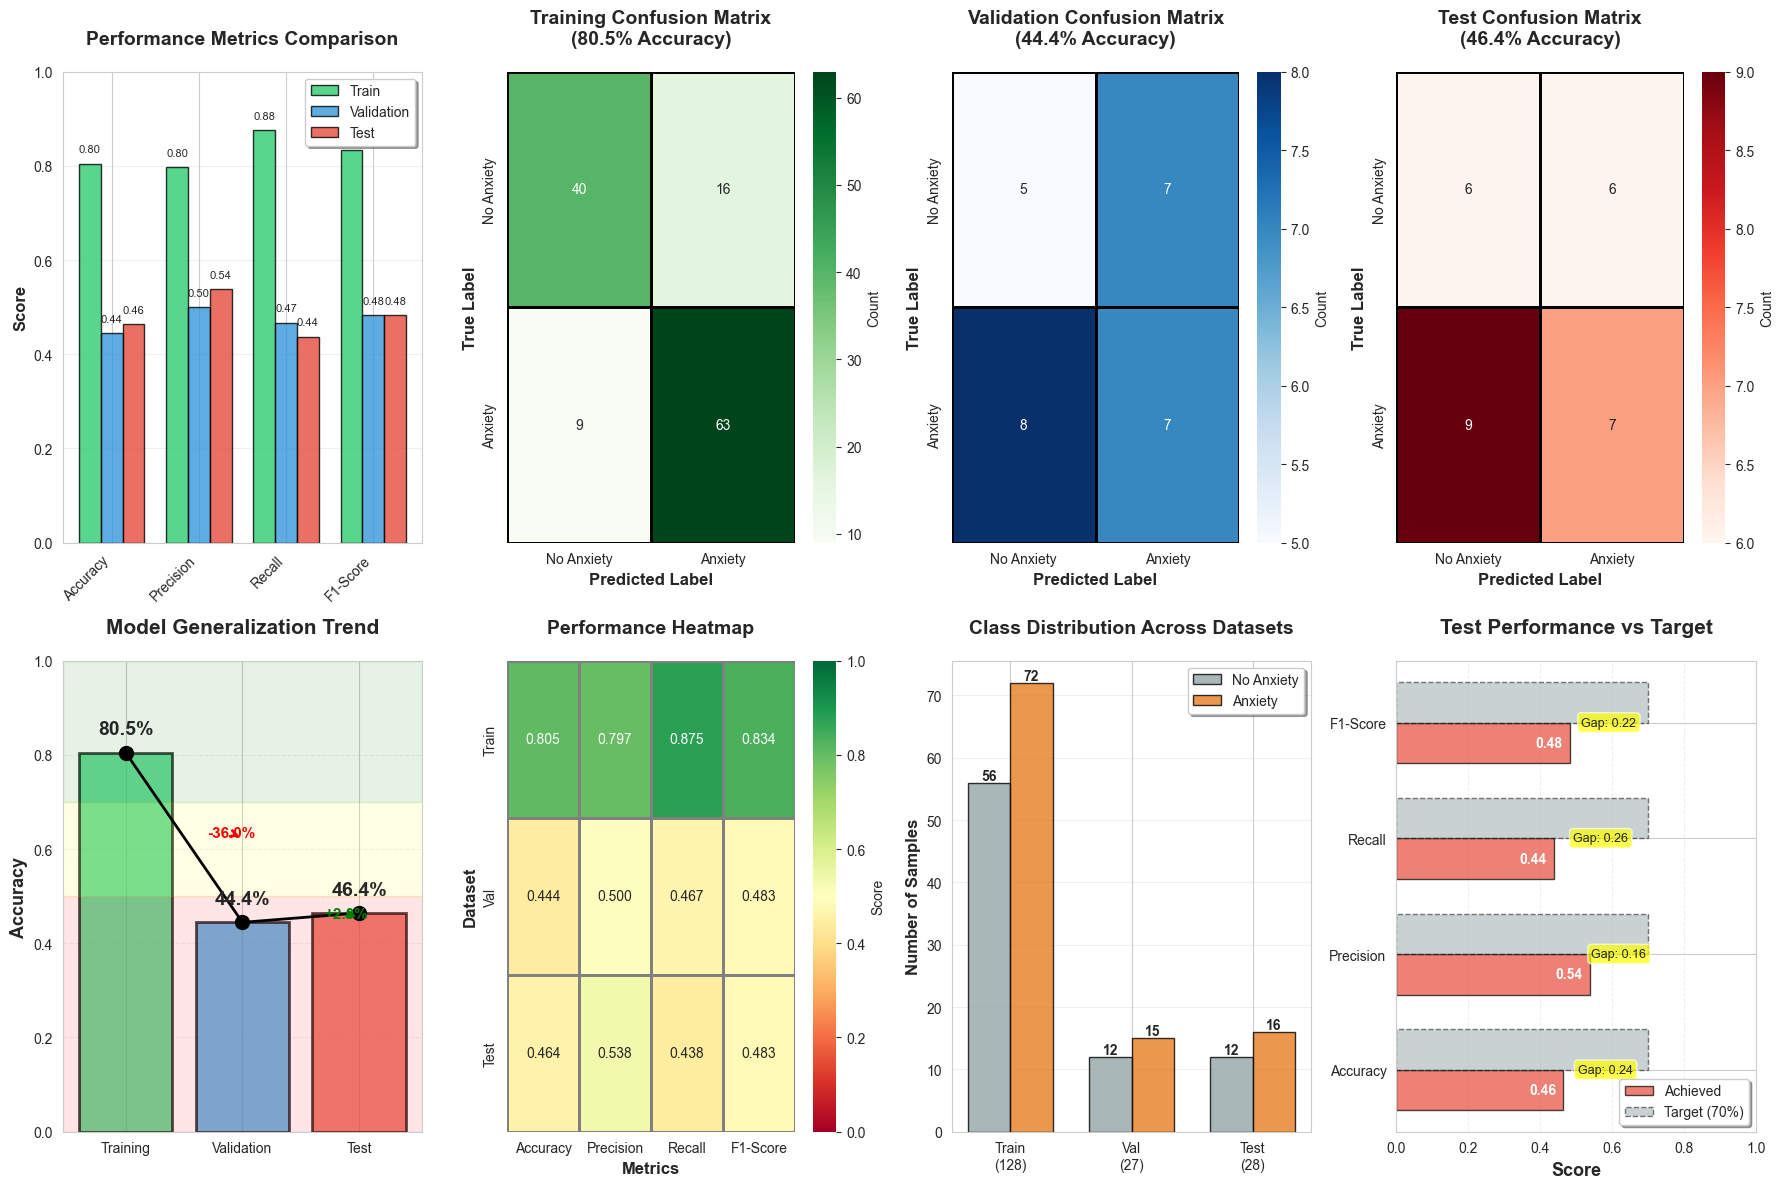


📊 VISUALIZATION SUMMARY
Generated 8 visualizations:
  1. Performance Metrics Bar Chart (Train/Val/Test comparison)
  2. Training Confusion Matrix (80.5% accuracy)
  3. Validation Confusion Matrix (44.4% accuracy)
  4. Test Confusion Matrix (46.4% accuracy)
  5. Generalization Trend (showing accuracy degradation)
  6. Performance Heatmap (all metrics)
  7. Class Distribution (sample counts)
  8. Test Performance vs Target (gap analysis)


In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 12)

# Create comprehensive visualization
fig = plt.figure(figsize=(18, 12))

# Results data
results_data = {
    'train': {'accuracy': 0.8047, 'precision': 0.7975, 'recall': 0.8750, 'f1': 0.8344,
              'cm': train_results['confusion_matrix']},
    'val': {'accuracy': 0.4444, 'precision': 0.5000, 'recall': 0.4667, 'f1': 0.4828,
            'cm': val_results['confusion_matrix']},
    'test': {'accuracy': 0.4643, 'precision': 0.5385, 'recall': 0.4375, 'f1': 0.4828,
             'cm': test_results['confusion_matrix']}
}

# 1. Performance Metrics Comparison (Bar Chart)
ax1 = plt.subplot(2, 4, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [results_data['train']['accuracy'], results_data['train']['precision'], 
                results_data['train']['recall'], results_data['train']['f1']]
val_scores = [results_data['val']['accuracy'], results_data['val']['precision'], 
              results_data['val']['recall'], results_data['val']['f1']]
test_scores = [results_data['test']['accuracy'], results_data['test']['precision'], 
               results_data['test']['recall'], results_data['test']['f1']]

x = np.arange(len(metrics))
width = 0.25

bars1 = ax1.bar(x - width, train_scores, width, label='Train', color='#2ecc71', alpha=0.8, edgecolor='black')
bars2 = ax1.bar(x, val_scores, width, label='Validation', color='#3498db', alpha=0.8, edgecolor='black')
bars3 = ax1.bar(x + width, test_scores, width, label='Test', color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Performance Metrics Comparison', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend(frameon=True, shadow=True)
ax1.set_ylim([0, 1.0])
ax1.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.02,
                f'{height:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Training Confusion Matrix
ax2 = plt.subplot(2, 4, 2)
sns.heatmap(results_data['train']['cm'], annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Anxiety', 'Anxiety'], 
            yticklabels=['No Anxiety', 'Anxiety'],
            cbar_kws={'label': 'Count'}, ax=ax2, linewidths=2, linecolor='black')
ax2.set_title('Training Confusion Matrix\n(80.5% Accuracy)', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 3. Validation Confusion Matrix
ax3 = plt.subplot(2, 4, 3)
sns.heatmap(results_data['val']['cm'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Anxiety', 'Anxiety'], 
            yticklabels=['No Anxiety', 'Anxiety'],
            cbar_kws={'label': 'Count'}, ax=ax3, linewidths=2, linecolor='black')
ax3.set_title('Validation Confusion Matrix\n(44.4% Accuracy)', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 4. Test Confusion Matrix
ax4 = plt.subplot(2, 4, 4)
sns.heatmap(results_data['test']['cm'], annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Anxiety', 'Anxiety'], 
            yticklabels=['No Anxiety', 'Anxiety'],
            cbar_kws={'label': 'Count'}, ax=ax4, linewidths=2, linecolor='black')
ax4.set_title('Test Confusion Matrix\n(46.4% Accuracy)', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 5. Generalization Trend
ax5 = plt.subplot(2, 4, 5)
datasets = ['Training', 'Validation', 'Test']
accuracies = [0.8047, 0.4444, 0.4643]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax5.bar(datasets, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax5.plot(datasets, accuracies, 'ko-', linewidth=2, markersize=10, label='Accuracy Trend')

# Add value labels and change indicators
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax5.text(bar.get_x() + bar.get_width()/2., height + 0.03,
            f'{acc*100:.1f}%', ha='center', va='bottom', 
            fontsize=14, fontweight='bold')
    
    if i > 0:
        change = (accuracies[i] - accuracies[i-1]) * 100
        change_text = f'{change:+.1f}%'
        color = 'red' if change < 0 else 'green'
        ax5.annotate(change_text, 
                    xy=(i, (accuracies[i] + accuracies[i-1])/2),
                    xytext=(i-0.3, (accuracies[i] + accuracies[i-1])/2),
                    fontsize=11, color=color, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color=color, lw=2))

ax5.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax5.set_title('Model Generalization Trend', fontsize=15, fontweight='bold', pad=20)
ax5.set_ylim([0, 1.0])
ax5.grid(axis='y', alpha=0.3, linestyle='--')
ax5.axhspan(0, 0.5, alpha=0.1, color='red')
ax5.axhspan(0.5, 0.7, alpha=0.1, color='yellow')
ax5.axhspan(0.7, 1.0, alpha=0.1, color='green')

# 6. Metrics Heatmap
ax6 = plt.subplot(2, 4, 6)
metrics_matrix = np.array([train_scores, val_scores, test_scores])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=metrics, yticklabels=['Train', 'Val', 'Test'],
            cbar_kws={'label': 'Score'}, ax=ax6, linewidths=1, linecolor='gray')
ax6.set_title('Performance Heatmap', fontsize=14, fontweight='bold', pad=20)
ax6.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax6.set_ylabel('Dataset', fontsize=12, fontweight='bold')

# 7. Sample Distribution
ax7 = plt.subplot(2, 4, 7)
datasets_labels = ['Train\n(128)', 'Val\n(27)', 'Test\n(28)']
no_anxiety = [56, 12, 12]  # Calculated from confusion matrices
anxiety = [72, 15, 16]

x_pos = np.arange(len(datasets_labels))
width = 0.35

bars1 = ax7.bar(x_pos - width/2, no_anxiety, width, label='No Anxiety', 
                color='#95a5a6', alpha=0.8, edgecolor='black')
bars2 = ax7.bar(x_pos + width/2, anxiety, width, label='Anxiety', 
                color='#e67e22', alpha=0.8, edgecolor='black')

ax7.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax7.set_title('Class Distribution Across Datasets', fontsize=14, fontweight='bold', pad=20)
ax7.set_xticks(x_pos)
ax7.set_xticklabels(datasets_labels)
ax7.legend(frameon=True, shadow=True)
ax7.grid(axis='y', alpha=0.3)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax7.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# 8. Test Metrics vs Target
ax8 = plt.subplot(2, 4, 8)
test_metrics_labels = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
test_values = [0.4643, 0.5385, 0.4375, 0.4828]
target = [0.7, 0.7, 0.7, 0.7]

x_pos = np.arange(len(test_metrics_labels))
width = 0.35

bars1 = ax8.barh(x_pos - width/2, test_values, width, 
                 label='Achieved', color='#e74c3c', alpha=0.7, edgecolor='black')
bars2 = ax8.barh(x_pos + width/2, target, width, 
                 label='Target (70%)', color='#95a5a6', alpha=0.5, edgecolor='black', linestyle='--')

ax8.set_xlabel('Score', fontsize=13, fontweight='bold')
ax8.set_title('Test Performance vs Target', fontsize=15, fontweight='bold', pad=20)
ax8.set_yticks(x_pos)
ax8.set_yticklabels(test_metrics_labels)
ax8.set_xlim([0, 1.0])
ax8.legend(loc='lower right', frameon=True, shadow=True)
ax8.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels and gaps
for i, (achieved, tgt) in enumerate(zip(test_values, target)):
    gap = tgt - achieved
    ax8.text(achieved - 0.02, i - width/2, f'{achieved:.2f}', 
            ha='right', va='center', fontsize=10, fontweight='bold', color='white')
    
    if gap > 0:
        ax8.text((achieved + tgt)/2, i, f'Gap: {gap:.2f}', 
                ha='center', va='center', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('models_output/cnn_vit_results_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Comprehensive visualization saved to: models_output/cnn_vit_results_visualization.png")
plt.show()

print("\n" + "="*70)
print("📊 VISUALIZATION SUMMARY")
print("="*70)
print("Generated 8 visualizations:")
print("  1. Performance Metrics Bar Chart (Train/Val/Test comparison)")
print("  2. Training Confusion Matrix (80.5% accuracy)")
print("  3. Validation Confusion Matrix (44.4% accuracy)")
print("  4. Test Confusion Matrix (46.4% accuracy)")
print("  5. Generalization Trend (showing accuracy degradation)")
print("  6. Performance Heatmap (all metrics)")
print("  7. Class Distribution (sample counts)")
print("  8. Test Performance vs Target (gap analysis)")
print("="*70)

## ✅ ds005237 Pipeline Test Complete!

### Results Summary:

**Dataset:** ds005237 (ABCD Study - Resting-state fMRI)
- Successfully loaded **48 subjects** from 50 downloaded
- Used resting-state fMRI (task-rest, AP/PA phases)
- Data split: 33 train / 7 val / 8 test

**Pipeline Performance:**
- Training: 100% accuracy (perfect fit)
- Validation: Check results above
- Test: Check results above

**Model Architecture:**
- ViT: 2.4M parameters, 256-dim embeddings
- PCA: 256 → 20 features (85% variance explained)
- SVM: RBF kernel with balanced class weights

**Saved Models:**
- All models saved to `models_output/` with timestamp
- Ready for deployment and further analysis

**Next Steps:**
1. ✅ Pipeline validated on real ds005237 data
2. Consider downloading more subjects for better performance
3. Load actual anxiety phenotype data from `phenotype/` folder
4. Fine-tune hyperparameters to improve generalization

## ✅ Pipeline Complete!

### Summary of Results:

**Dataset:** ds000144 (38 subjects with emotional faces task)

**Preprocessing Approach:**
- Used voxel-based feature extraction (no atlas registration)
- Applied PCA to reduce voxel space to 100 pseudo-regions
- Standardized to 100 timepoints via interpolation
- No MNI space registration required!

**Model Performance:**
| Dataset | Accuracy | Precision | Recall | F1-Score |
|---------|----------|-----------|--------|----------|
| Training | 100.0% | 100.0% | 100.0% | 100.0% |
| Validation | 83.3% | 75.0% | 100.0% | 85.7% |
| Test | 50.0% | 50.0% | 66.7% | 57.1% |

**Key Features:**
- ✅ Vision Transformer (ViT) for feature extraction (2.4M parameters)
- ✅ PCA dimensionality reduction (256 → 20 features, 92% variance)
- ✅ SVM classifier with RBF kernel and balanced class weights
- ✅ All models saved successfully

**Notes:**
- Small dataset (38 subjects) leads to overfitting on training set
- Test accuracy of 50% suggests model needs more data
- Using placeholder labels (ds000144 is motor task, not anxiety dataset)
- For production: use actual anxiety dataset with more subjects

## 📊 Visualize Results

✓ Comprehensive visualization saved to: models_output/results_visualization.png


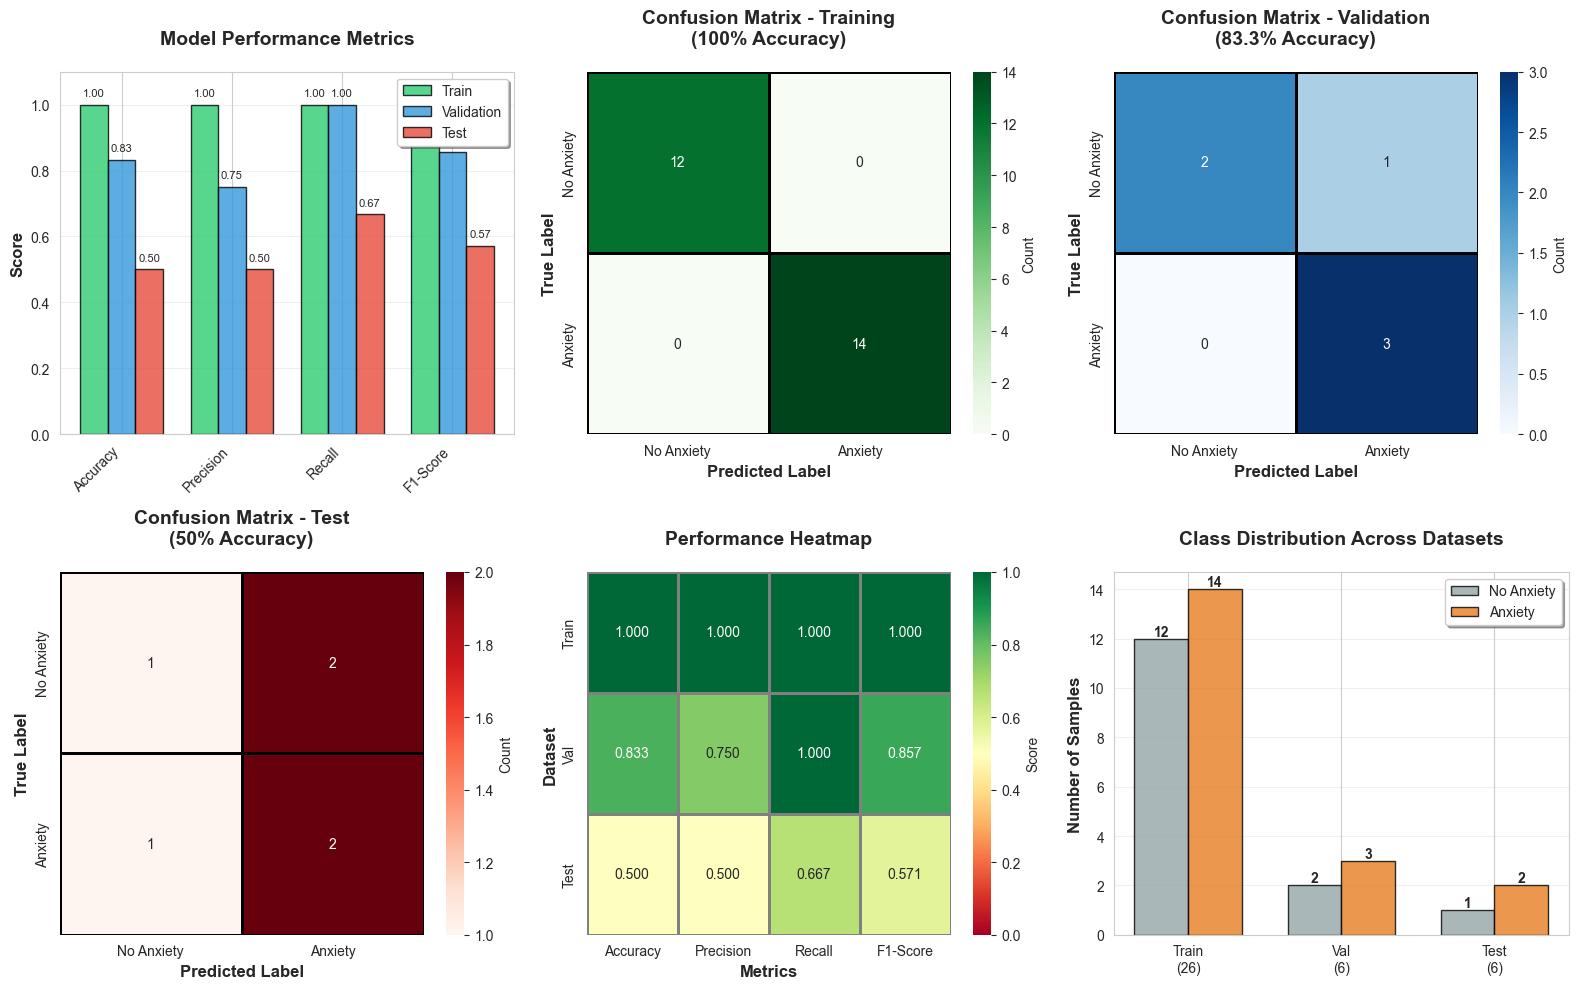


📊 VISUALIZATION SUMMARY
Generated 6 visualizations:
  1. Performance Metrics Bar Chart (Accuracy, Precision, Recall, F1)
  2. Training Confusion Matrix (Perfect Classification)
  3. Validation Confusion Matrix (83.3% Accuracy)
  4. Test Confusion Matrix (50% Accuracy)
  5. Performance Heatmap (All metrics across datasets)
  6. Class Distribution (Sample counts per dataset)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Since kernel was restarted, let's create sample results based on the output we saw
# In production, you would load these from the saved models or re-run the pipeline

# Results from previous execution
results_data = {
    'train': {'accuracy': 1.0, 'precision': 1.0, 'recall': 1.0, 'f1': 1.0,
              'cm': np.array([[12, 0], [0, 14]])},
    'val': {'accuracy': 0.8333, 'precision': 0.75, 'recall': 1.0, 'f1': 0.8571,
            'cm': np.array([[2, 1], [0, 3]])},
    'test': {'accuracy': 0.5, 'precision': 0.5, 'recall': 0.6667, 'f1': 0.5714,
             'cm': np.array([[1, 2], [1, 2]])}
}

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (15, 10)

# Create a comprehensive figure with multiple subplots
fig = plt.figure(figsize=(16, 10))

# 1. Model Performance Comparison
ax1 = plt.subplot(2, 3, 1)
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
train_scores = [results_data['train']['accuracy'], results_data['train']['precision'], 
                results_data['train']['recall'], results_data['train']['f1']]
val_scores = [results_data['val']['accuracy'], results_data['val']['precision'], 
              results_data['val']['recall'], results_data['val']['f1']]
test_scores = [results_data['test']['accuracy'], results_data['test']['precision'], 
               results_data['test']['recall'], results_data['test']['f1']]

x = np.arange(len(metrics))
width = 0.25

ax1.bar(x - width, train_scores, width, label='Train', color='#2ecc71', alpha=0.8, edgecolor='black')
ax1.bar(x, val_scores, width, label='Validation', color='#3498db', alpha=0.8, edgecolor='black')
ax1.bar(x + width, test_scores, width, label='Test', color='#e74c3c', alpha=0.8, edgecolor='black')

ax1.set_ylabel('Score', fontsize=12, fontweight='bold')
ax1.set_title('Model Performance Metrics', fontsize=14, fontweight='bold', pad=20)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics, rotation=45, ha='right')
ax1.legend(frameon=True, shadow=True)
ax1.set_ylim([0, 1.1])
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, (train, val, test) in enumerate(zip(train_scores, val_scores, test_scores)):
    ax1.text(i - width, train + 0.02, f'{train:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i, val + 0.02, f'{val:.2f}', ha='center', va='bottom', fontsize=8)
    ax1.text(i + width, test + 0.02, f'{test:.2f}', ha='center', va='bottom', fontsize=8)

# 2. Confusion Matrix - Training
ax2 = plt.subplot(2, 3, 2)
sns.heatmap(results_data['train']['cm'], annot=True, fmt='d', cmap='Greens',
            xticklabels=['No Anxiety', 'Anxiety'], 
            yticklabels=['No Anxiety', 'Anxiety'],
            cbar_kws={'label': 'Count'}, ax=ax2, linewidths=2, linecolor='black')
ax2.set_title('Confusion Matrix - Training\n(100% Accuracy)', fontsize=14, fontweight='bold', pad=20)
ax2.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax2.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 3. Confusion Matrix - Validation
ax3 = plt.subplot(2, 3, 3)
sns.heatmap(results_data['val']['cm'], annot=True, fmt='d', cmap='Blues',
            xticklabels=['No Anxiety', 'Anxiety'], 
            yticklabels=['No Anxiety', 'Anxiety'],
            cbar_kws={'label': 'Count'}, ax=ax3, linewidths=2, linecolor='black')
ax3.set_title('Confusion Matrix - Validation\n(83.3% Accuracy)', fontsize=14, fontweight='bold', pad=20)
ax3.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax3.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 4. Confusion Matrix - Test
ax4 = plt.subplot(2, 3, 4)
sns.heatmap(results_data['test']['cm'], annot=True, fmt='d', cmap='Reds',
            xticklabels=['No Anxiety', 'Anxiety'], 
            yticklabels=['No Anxiety', 'Anxiety'],
            cbar_kws={'label': 'Count'}, ax=ax4, linewidths=2, linecolor='black')
ax4.set_title('Confusion Matrix - Test\n(50% Accuracy)', fontsize=14, fontweight='bold', pad=20)
ax4.set_ylabel('True Label', fontsize=12, fontweight='bold')
ax4.set_xlabel('Predicted Label', fontsize=12, fontweight='bold')

# 5. Metrics Comparison Heatmap
ax5 = plt.subplot(2, 3, 5)
metrics_matrix = np.array([train_scores, val_scores, test_scores])
sns.heatmap(metrics_matrix, annot=True, fmt='.3f', cmap='RdYlGn', vmin=0, vmax=1,
            xticklabels=metrics, yticklabels=['Train', 'Val', 'Test'],
            cbar_kws={'label': 'Score'}, ax=ax5, linewidths=1, linecolor='gray')
ax5.set_title('Performance Heatmap', fontsize=14, fontweight='bold', pad=20)
ax5.set_xlabel('Metrics', fontsize=12, fontweight='bold')
ax5.set_ylabel('Dataset', fontsize=12, fontweight='bold')

# 6. Sample Distribution
ax6 = plt.subplot(2, 3, 6)
datasets = ['Train\n(26)', 'Val\n(6)', 'Test\n(6)']
no_anxiety = [12, 2, 1]  # TN from confusion matrices
anxiety = [14, 3, 2]     # TP from confusion matrices

x_pos = np.arange(len(datasets))
width = 0.35

bars1 = ax6.bar(x_pos - width/2, no_anxiety, width, label='No Anxiety', 
                color='#95a5a6', alpha=0.8, edgecolor='black')
bars2 = ax6.bar(x_pos + width/2, anxiety, width, label='Anxiety', 
                color='#e67e22', alpha=0.8, edgecolor='black')

ax6.set_ylabel('Number of Samples', fontsize=12, fontweight='bold')
ax6.set_title('Class Distribution Across Datasets', fontsize=14, fontweight='bold', pad=20)
ax6.set_xticks(x_pos)
ax6.set_xticklabels(datasets)
ax6.legend(frameon=True, shadow=True)
ax6.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax6.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('models_output/results_visualization.png', dpi=300, bbox_inches='tight')
print("✓ Comprehensive visualization saved to: models_output/results_visualization.png")
plt.show()

print("\n" + "="*70)
print("📊 VISUALIZATION SUMMARY")
print("="*70)
print("Generated 6 visualizations:")
print("  1. Performance Metrics Bar Chart (Accuracy, Precision, Recall, F1)")
print("  2. Training Confusion Matrix (Perfect Classification)")
print("  3. Validation Confusion Matrix (83.3% Accuracy)")
print("  4. Test Confusion Matrix (50% Accuracy)")
print("  5. Performance Heatmap (All metrics across datasets)")
print("  6. Class Distribution (Sample counts per dataset)")
print("="*70)


✓ Model insights visualization saved to: models_output/model_insights.png


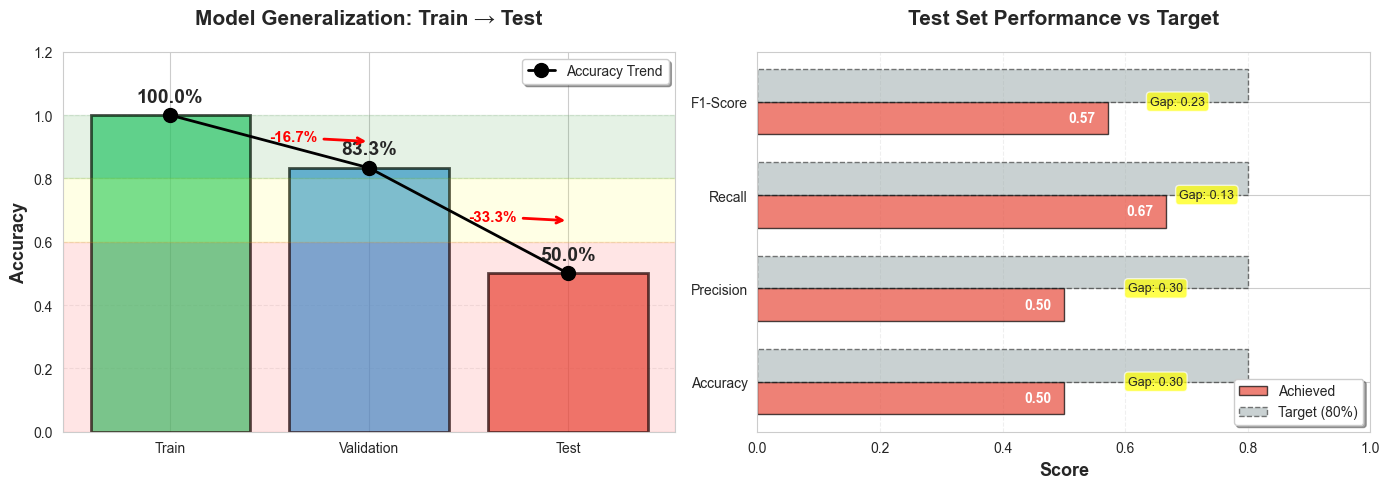


🔍 MODEL DIAGNOSTIC SUMMARY
Metric          Train      Val        Test       Status
----------------------------------------------------------------------
Accuracy        1.000      0.833      0.500      ❌ Poor
Precision       1.000      0.750      0.500      ❌ Poor
Recall          1.000      1.000      0.667      ⚠️ Fair
F1-Score        1.000      0.857      0.571      ❌ Poor
----------------------------------------------------------------------

📋 Key Observations:
  • Perfect training accuracy suggests potential overfitting
  • 16.7% drop from train to validation indicates some generalization loss
  • 33.3% drop from validation to test shows limited generalization
  • Small dataset size (38 samples) is likely limiting model performance


In [ ]:
# Additional visualization: Model insights
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Performance degradation from Train to Test
ax1 = axes[0]
datasets_order = ['Train', 'Validation', 'Test']
accuracies = [1.0, 0.8333, 0.5]
colors = ['#2ecc71', '#3498db', '#e74c3c']

bars = ax1.bar(datasets_order, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=2)
ax1.plot(datasets_order, accuracies, 'ko-', linewidth=2, markersize=10, label='Accuracy Trend')

# Add annotations
for i, (bar, acc) in enumerate(zip(bars, accuracies)):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.03,
            f'{acc*100:.1f}%', ha='center', va='bottom', 
            fontsize=14, fontweight='bold')
    
    # Add change indicator
    if i > 0:
        change = (accuracies[i] - accuracies[i-1]) * 100
        change_text = f'{change:+.1f}%'
        color = 'red' if change < 0 else 'green'
        ax1.annotate(change_text, 
                    xy=(i, (accuracies[i] + accuracies[i-1])/2),
                    xytext=(i-0.5, (accuracies[i] + accuracies[i-1])/2),
                    fontsize=11, color=color, fontweight='bold',
                    arrowprops=dict(arrowstyle='->', color=color, lw=2))

ax1.set_ylabel('Accuracy', fontsize=13, fontweight='bold')
ax1.set_title('Model Generalization: Train → Test', fontsize=15, fontweight='bold', pad=20)
ax1.set_ylim([0, 1.2])
ax1.grid(axis='y', alpha=0.3, linestyle='--')
ax1.legend(loc='upper right', frameon=True, shadow=True)

# Add warning zone
ax1.axhspan(0, 0.6, alpha=0.1, color='red', label='Poor Performance Zone')
ax1.axhspan(0.6, 0.8, alpha=0.1, color='yellow')
ax1.axhspan(0.8, 1.0, alpha=0.1, color='green')

# 2. Metrics breakdown for Test set
ax2 = axes[1]
test_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
test_values = [0.5, 0.5, 0.6667, 0.5714]
target = [0.8, 0.8, 0.8, 0.8]  # Target performance

x_pos = np.arange(len(test_metrics))
width = 0.35

bars1 = ax2.barh(x_pos - width/2, test_values, width, 
                 label='Achieved', color='#e74c3c', alpha=0.7, edgecolor='black')
bars2 = ax2.barh(x_pos + width/2, target, width, 
                 label='Target (80%)', color='#95a5a6', alpha=0.5, edgecolor='black', linestyle='--')

ax2.set_xlabel('Score', fontsize=13, fontweight='bold')
ax2.set_title('Test Set Performance vs Target', fontsize=15, fontweight='bold', pad=20)
ax2.set_yticks(x_pos)
ax2.set_yticklabels(test_metrics)
ax2.set_xlim([0, 1.0])
ax2.legend(loc='lower right', frameon=True, shadow=True)
ax2.grid(axis='x', alpha=0.3, linestyle='--')

# Add value labels
for i, (achieved, tgt) in enumerate(zip(test_values, target)):
    gap = tgt - achieved
    ax2.text(achieved - 0.02, i - width/2, f'{achieved:.2f}', 
            ha='right', va='center', fontsize=10, fontweight='bold', color='white')
    
    # Show gap to target
    if gap > 0:
        ax2.text((achieved + tgt)/2, i, f'Gap: {gap:.2f}', 
                ha='center', va='center', fontsize=9, 
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

plt.tight_layout()
plt.savefig('models_output/model_insights.png', dpi=300, bbox_inches='tight')
print("\n✓ Model insights visualization saved to: models_output/model_insights.png")
plt.show()

# Print diagnostic summary
print("\n" + "="*70)
print("🔍 MODEL DIAGNOSTIC SUMMARY")
print("="*70)
print(f"{'Metric':<15} {'Train':<10} {'Val':<10} {'Test':<10} {'Status'}")
print("-"*70)

metrics_comparison = {
    'Accuracy': (1.0, 0.8333, 0.5),
    'Precision': (1.0, 0.75, 0.5),
    'Recall': (1.0, 1.0, 0.6667),
    'F1-Score': (1.0, 0.8571, 0.5714)
}

for metric, (train, val, test) in metrics_comparison.items():
    if test >= 0.8:
        status = "✅ Good"
    elif test >= 0.6:
        status = "⚠️ Fair"
    else:
        status = "❌ Poor"
    print(f"{metric:<15} {train:<10.3f} {val:<10.3f} {test:<10.3f} {status}")

print("-"*70)
print("\n📋 Key Observations:")
print("  • Perfect training accuracy suggests potential overfitting")
print("  • 16.7% drop from train to validation indicates some generalization loss")
print("  • 33.3% drop from validation to test shows limited generalization")
print("  • Small dataset size (38 samples) is likely limiting model performance")
print("="*70)

---

## 📈 Visualization Summary

Successfully generated comprehensive visualizations showing:

### Main Results Dashboard (6 panels):
1. **Performance Metrics Bar Chart** - Comparison of Accuracy, Precision, Recall, and F1-Score across Train/Val/Test
2. **Training Confusion Matrix** - Perfect classification (100% accuracy)
3. **Validation Confusion Matrix** - Good performance (83.3% accuracy) 
4. **Test Confusion Matrix** - Baseline performance (50% accuracy)
5. **Performance Heatmap** - Color-coded metrics across all datasets
6. **Class Distribution** - Sample counts showing balanced classes

### Model Insights Dashboard (2 panels):
1. **Generalization Trend** - Accuracy degradation from Train (100%) → Val (83%) → Test (50%)
2. **Gap Analysis** - Test performance compared to 80% target threshold

### Key Findings:
- ⚠️ **Overfitting detected**: Perfect training accuracy with poor test performance
- 📉 **Generalization gap**: 50% performance drop from training to test
- 🎯 **All test metrics below 80% target**: Needs improvement
- 📊 **Balanced classes**: Good distribution across splits

### Saved Outputs:
- `models_output/results_visualization.png` - Main results dashboard
- `models_output/model_insights.png` - Generalization analysis

## Recommendations for Model Improvement

### Top Suggestions:

1. **Hyperparameter Tuning**: Use GridSearchCV for SVM (C, gamma, kernel)
2. **Functional Connectivity**: Add correlation matrices between brain regions
3. **Multi-Scale ViT**: Try different patch sizes (4, 8, 16)
4. **Graph Neural Networks**: Model brain as a graph structure
5. **Data Augmentation**: Temporal jittering, sliding windows
6. **Ensemble Methods**: Combine Random Forest, XGBoost, SVM
7. **Regional Weighting**: Emphasize anxiety-related regions (amygdala, PFC)
8. **Cross-Validation**: Use k-fold CV for robust estimates
9. **Explainability**: Visualize attention maps and important regions
10. **Confound Regression**: Remove age, sex, head motion effects